In [34]:
#구글 드라이브 연결
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### pip

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
# 설치 후 런타임 다시시작

In [ ]:
import sklearn

!pip install pycaret

from pycaret.utils import enable_colab
enable_colab()

!pip install markupsafe==2.0.1
# 설치 후 런타임 다시시작

In [ ]:
import jinja2
from pycaret.regression import *

!pip install catboost

!pip install optuna

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

#### h2o automl

In [ ]:
## 0. h2o setup
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip uninstall h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [7]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init()
h2o.no_progress()
# H2O 클러스터 가동 시간, 시간대, 버전, 버전 수명, 클러스터 이름, 할당 된 하드웨어 리소스 (노드 수, 메모리, 코어 수), 연결 URL, 노출 된 H2O API 확장 및 사용 된 파이썬 버전과 같은 추가 정보가 출력

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp40oeicnj
  JVM stdout: /tmp/tmp40oeicnj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp40oeicnj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.365 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### import


In [57]:
# 함수
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import re

# 전처리
import datetime as dt

# 모델
from pycaret.regression import * 
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesRegressor

# 경고
import warnings
warnings.filterwarnings(action='ignore')

# 성능 평가
from sklearn.metrics import *
from sklearn.model_selection import KFold

def NRMSE(y, pred):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(1,15): # ignore 'ID'
        rmse = metrics.mean_squared_error(y[:,idx], pred[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(y[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

# 데이터
train = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/train.csv')
test = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/test.csv')
sample_submission = pd.read_csv('./drive/MyDrive/input/자율주행 센서의 안테나 성능 예측 AI 경진대회/sample_submission.csv')
sample_submission

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# 시드 고정
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

Data Load

In [4]:
X_train = train.filter(regex='X') # Input : X Featrue
y_train = train.filter(regex='Y') # Output : Y Feature
X_test = test.iloc[:, 1:]
X_test.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,68.504,103.321,76.67,1,101.867,73.963,30.51,63.57,239.80,0.0,0.0,4.37,0.15,13.38,13.40,13.50,13.53,13.46,3.27,3.32,3.18,3.39,1,2.22,2.14,2.31,2.16,2.32,2.22,1.38,1.53,1.33,1.53,12.96,12.95,12.97,12.88,-16.17,-16.17,-16.84,21.22,21.06,21.21,21.20,0.16,1469,1,1,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,67.485,103.320,69.37,1,101.992,67.845,28.03,116.99,189.23,0.0,0.0,4.36,0.17,13.35,13.38,13.45,13.52,13.44,3.26,3.30,3.17,3.34,1,2.11,2.10,2.10,2.10,2.17,2.20,1.36,1.56,1.34,1.55,12.94,12.89,13.00,12.88,-15.35,-15.25,-16.01,21.21,20.99,21.26,21.15,0.27,1462,1,1,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,69.524,103.320,68.97,1,101.884,77.022,29.65,205.68,214.93,0.0,0.0,4.43,0.20,13.32,13.35,13.40,13.52,13.41,3.07,3.12,3.05,3.17,1,2.13,2.10,2.29,2.15,2.24,2.26,1.50,1.69,1.47,1.71,12.93,12.90,13.02,13.01,-16.27,-16.35,-16.95,21.16,21.05,21.15,21.19,0.14,1469,1,1,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,69.524,103.320,65.87,1,101.866,73.963,28.15,103.38,180.80,0.0,0.0,4.39,0.18,13.32,13.34,13.45,13.50,13.42,3.23,3.11,3.20,3.14,1,2.10,2.10,2.09,2.09,2.10,2.18,1.49,1.65,1.46,1.90,12.99,12.98,12.91,12.96,-16.06,-16.13,-16.75,21.15,21.03,21.16,21.14,0.13,1469,1,1,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,73.603,103.321,66.67,1,101.891,74.983,29.92,71.20,231.93,0.0,0.0,4.38,0.12,13.38,13.39,13.45,13.50,13.46,3.17,3.20,3.04,3.20,1,2.12,2.11,2.10,2.10,2.12,2.18,1.48,1.73,1.46,1.67,13.01,12.84,12.99,13.01,-16.06,-16.17,-16.76,21.15,21.08,21.12,21.17,0.09,1469,1,1,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016


In [5]:
# pycaret 데이터 제작
for i in range(1, 15):
  globals()['train{0}'.format(i)] = pd.concat([X_train, y_train.iloc[:, i-1:i]],axis=1)

train1.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,Y_01
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,0.0,4.34,0.18,13.34,13.37,13.40,13.52,13.44,3.11,3.17,3.06,3.13,1,2.05,2.07,2.05,2.06,2.06,2.35,1.49,1.69,1.46,1.74,12.99,12.88,12.89,12.99,-16.41,-16.36,-17.03,21.20,20.99,21.28,21.09,0.29,1463,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,2.056
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,0.0,4.38,0.18,13.33,13.33,13.46,13.51,13.42,2.97,3.11,2.91,3.20,1,2.10,2.10,2.10,2.10,2.17,2.28,1.49,1.67,1.45,1.66,12.92,12.87,12.89,12.93,-16.06,-16.11,-16.74,21.16,21.03,21.16,21.13,0.13,1463,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1.446
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,0.0,4.36,0.15,13.36,13.36,13.39,13.51,13.43,3.04,3.04,3.01,3.12,1,2.07,2.06,2.04,2.07,2.10,2.26,1.49,1.69,1.46,1.68,12.97,12.87,12.87,13.00,-16.16,-16.17,-16.76,21.13,21.03,21.17,21.12,0.14,1468,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1.251
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,0.0,4.33,0.21,13.30,13.33,13.39,13.51,13.40,3.05,3.01,3.02,3.08,1,2.06,2.05,2.03,2.06,2.07,2.12,1.47,1.68,1.47,1.68,12.91,12.97,12.99,12.92,-16.05,-16.03,-16.67,21.18,20.98,21.20,21.09,0.22,1469,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1.464
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,0.0,4.35,0.16,13.35,13.34,13.41,13.50,13.42,3.04,3.07,3.00,3.12,1,2.09,2.06,2.09,2.12,2.33,2.13,1.49,1.68,1.47,1.82,12.96,12.85,12.91,12.96,-16.25,-16.23,-16.85,21.16,20.96,21.18,21.10,0.22,1469,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0.983


#### h2o automl

##### 1번

In [8]:
# 1시간
train_1 = train1.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_1, test_size=0.2, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_1.columns)
y = "Y_01"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20220810_43910_model_10,0.350022,0.122515,0.270506,0.151344,0.122515
GBM_grid_1_AutoML_1_20220810_43910_model_4,0.350025,0.122518,0.269985,0.151345,0.122518
GBM_grid_1_AutoML_1_20220810_43910_model_15,0.350138,0.122597,0.270314,0.151348,0.122597
GBM_grid_1_AutoML_1_20220810_43910_model_3,0.350183,0.122628,0.270564,0.151366,0.122628
GBM_grid_1_AutoML_1_20220810_43910_model_8,0.35022,0.122654,0.27019,0.151413,0.122654
GBM_grid_1_AutoML_1_20220810_43910_model_17,0.350237,0.122666,0.269991,0.151399,0.122666
GBM_3_AutoML_1_20220810_43910,0.3503,0.12271,0.270515,0.151376,0.12271
GBM_grid_1_AutoML_1_20220810_43910_model_2,0.350353,0.122748,0.270232,0.151468,0.122748
GBM_grid_1_AutoML_1_20220810_43910_model_18,0.350399,0.12278,0.270567,0.151455,0.12278
GBM_2_AutoML_1_20220810_43910,0.350545,0.122882,0.27087,0.151492,0.122882


In [9]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.122515402084999
RMSE: 0.35002200228699765
MAE: 0.2705063358662359
RMSLE: 0.151344291963435
Mean Residual Deviance: 0.122515402084999


[('X_07', 238.72335815429688, 1.0, 0.09283004500576388), ('X_22', 163.4853515625, 0.6848318188320415, 0.06357296856355756), ('X_49', 119.52706146240234, 0.5006927783964358, 0.046479333152602095), ('X_19', 117.50885772705078, 0.4922386256442484, 0.04569453377213094), ('X_20', 115.12755584716797, 0.4822634732406714, 0.044768539925567535), ('X_03', 113.40416717529297, 0.47504428578788305, 0.044098382429420144), ('X_09', 110.14375305175781, 0.46138657692879514, 0.04283053670135539), ('X_13', 75.0406723022461, 0.31434155787027834, 0.02918034096427987), ('X_21', 67.2330551147461, 0.2816358467581985, 0.026144268329799988), ('X_05', 62.85987854003906, 0.2633168326134642, 0.02444371342228308), ('X_06', 59.198184967041016, 0.247978184559463, 0.023019826033102573), ('X_52', 56.19681930541992, 0.2354056165257929, 0.021852713976698947), ('X_56', 55.040809631347656, 0.2305631508240282, 0.021403187667665264), ('X_16', 54.57040023803711, 0.22859262981197667, 0.021220264113431718), ('X_43', 53.63793563

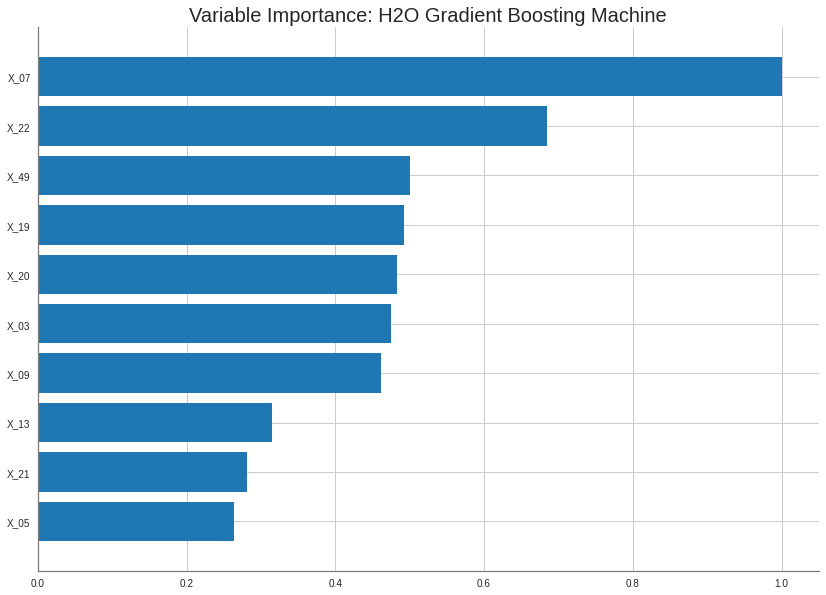

predict
1.24947
1.34341
1.37046
1.27057
1.42831
1.39829
1.45706
1.3495
1.42304
1.39371


Y_01
1.326
1.069
1.278
1.476
1.428
1.44
1.282
1.263
0.471
1.486


<Figure size 432x288 with 0 Axes>

In [10]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)
# [('X_07', 283.6393737792969, 1.0, 0.12518358836648696), ('X_22', 153.10166931152344, 0.5397757979491721, 0.0675710713006612), ('X_49', 151.04347229003906, 0.5325194111011109, 0.06666269075644553), ('X_03', 140.07815551757812, 0.493860050708526, 0.06182317329854851), ('X_09', 128.74620056152344, 0.4539080694124729, 0.056821840917557806), ('X_19', 96.48343658447266, 0.3401623522816954, 0.04258274388580768), ('X_20', 74.9245834350586, 0.2641543818008789, 0.033067793396565064), ('X_21', 72.5791015625, 0.2558851424449084, 0.0320326203409233), ('X_13', 70.29818725585938, 0.2478435427323966, 0.03102594403270416), ('X_18', 65.27365112304688, 0.23012902000635874, 0.02880837651165906), ('X_52', 59.8654670715332, 0.21106190679336087, 0.02642148685986593), ('X_43', 59.586097717285156, 0.21007696118963298, 0.026298187834845478), ('X_05', 58.193382263183594, 0.2051667985576098, 0.02568351605710578), ('X_51', 49.08327102661133, 0.17304815749876673, 0.02166278931590462), ('X_55', 44.14694595336914, 0.15564463200275008, 0.01948415354408561), ('X_06', 42.07295608520508, 0.14833256583743037, 0.018568802863137713), ('X_08', 41.22038650512695, 0.14532674344853483, 0.01819252323050344), ('X_17', 38.10068130493164, 0.134327899534069, 0.016815648481407715), ('X_56', 35.987606048583984, 0.1268780337830895, 0.015883047553851507), ('X_45', 33.45148468017578, 0.11793667513243339, 0.014763736193090642), ('X_14', 33.420860290527344, 0.11782870567374933, 0.014750220188818584), ('X_28', 32.55638885498047, 0.11478092206025309, 0.014368687699516547), ('X_01', 30.54311752319336, 0.10768292538594912, 0.013480135005613786), ('X_31', 30.49063491821289, 0.10749789252439265, 0.013456971928038427), ('X_32', 29.94219398498535, 0.1055643071905938, 0.013214918777540675), ('X_26', 26.549428939819336, 0.09360276250108265, 0.011717529690901573), ('X_29', 25.31772232055664, 0.08926025319833296, 0.011173918793868516), ('X_46', 25.054241180419922, 0.0883313231396249, 0.01105763199577795), ('X_34', 24.32987403869629, 0.08577749173014199, 0.010737934215855834), ('X_53', 23.106868743896484, 0.08146565984832631, 0.010198163628457126), ('X_50', 22.42790985107422, 0.07907191992507231, 0.009898506675248072), ('X_25', 21.57439613342285, 0.07606276888134066, 0.009521810349656983), ('X_27', 21.453689575195312, 0.07563720540396017, 0.009468536786480774), ('X_44', 19.267879486083984, 0.0679309054640508, 0.008503834506974476), ('X_37', 17.860864639282227, 0.06297032884150977, 0.007882851724997881), ('X_54', 17.202125549316406, 0.060647875928190355, 0.007592118735496356), ('X_33', 16.40506362915039, 0.05783775154543728, 0.007240337281507167), ('X_42', 16.021411895751953, 0.05648514760936682, 0.007071013467151232), ('X_40', 15.91661262512207, 0.056115666922558406, 0.007024760548944441), ('X_16', 15.743875503540039, 0.055506664303209656, 0.006948523415729774), ('X_24', 15.417304992675781, 0.05435530613134186, 0.006804392268280285), ('X_39', 14.113567352294922, 0.04975884400054011, 0.006228990644955854), ('X_36', 13.353354454040527, 0.047078634662446155, 0.0058934724224398854), ('X_30', 12.50938892364502, 0.04410314674216818, 0.005520990167438352), ('X_38', 12.240413665771484, 0.04315484660213604, 0.0054022785530606875), ('X_35', 10.450654029846191, 0.03684486356953379, 0.004612372234507889), ('X_41', 8.931245803833008, 0.03148803244355812, 0.003941784891884966), ('X_15', 8.370869636535645, 0.029512368205442157, 0.0036944641531502687), ('X_12', 7.339144229888916, 0.02587491338772871, 0.0032391145065479338), ('X_02', 0.0, 0.0, 0.0), ('X_10', 0.0, 0.0, 0.0), ('X_11', 0.0, 0.0, 0.0)]

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_01'])

In [11]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred1 = aml.predict(h2o_test)
pred1

predict
1.37952
1.49285
1.40445
1.42154
1.4121
1.37713
1.38863
1.4104
1.40399
1.36276


In [12]:
df = h2o_test.cbind(pred1)
res = df[:, ["predict"]]
res.set_names(['Y_01'])
h2o.export_file(res, path = "pred1.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_01.pkl', 'wb') as f:
 pickle.dump(preds, f)

##### 2번

In [ ]:
# 1시간
train_2 = train2.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_2, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_2.columns)
y = "Y_02"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_9_20220809_144449_model_4,0.377997,0.142882,0.296933,0.186564,0.142882
GBM_grid_1_AutoML_9_20220809_144449_model_2,0.378281,0.143096,0.296934,0.186666,0.143096
GBM_grid_1_AutoML_9_20220809_144449_model_6,0.378305,0.143115,0.2973,0.186748,0.143115
GBM_grid_1_AutoML_9_20220809_144449_model_17,0.378312,0.14312,0.297219,0.186685,0.14312
GBM_grid_1_AutoML_9_20220809_144449_model_5,0.378324,0.143129,0.297475,0.186781,0.143129
GBM_grid_1_AutoML_9_20220809_144449_model_3,0.378593,0.143333,0.297384,0.186821,0.143333
GBM_5_AutoML_9_20220809_144449,0.378616,0.14335,0.297659,0.186872,0.14335
GBM_grid_1_AutoML_9_20220809_144449_model_18,0.378676,0.143396,0.29753,0.18691,0.143396
GBM_grid_1_AutoML_9_20220809_144449_model_1,0.378727,0.143434,0.297704,0.18695,0.143434
GBM_grid_1_AutoML_9_20220809_144449_model_10,0.378793,0.143484,0.297577,0.187016,0.143484


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.1428817262350638
RMSE: 0.37799699236245754
MAE: 0.2969331630737559
RMSLE: 0.18656354189544505
Mean Residual Deviance: 0.1428817262350638


[('X_22', 293.22723388671875, 1.0, 0.15616013740639784), ('X_49', 118.7031021118164, 0.40481608934617064, 0.06321613613661863), ('X_07', 99.7021255493164, 0.34001659473360485, 0.05309703815405521), ('X_09', 97.42523193359375, 0.33225164880568914, 0.05188446313099865), ('X_03', 95.1593246459961, 0.3245241698210017, 0.0506777389509448), ('X_05', 83.65583801269531, 0.2852935482964509, 0.04455147970313257), ('X_13', 81.39312744140625, 0.2775769711514945, 0.0433464579558691), ('X_43', 64.1651840209961, 0.21882409478304038, 0.03417160070915021), ('X_25', 53.658565521240234, 0.18299311701030446, 0.028576230296754178), ('X_20', 49.980892181396484, 0.1704510577646597, 0.026617660601595115), ('X_18', 47.70722579956055, 0.16269711775131732, 0.0254068042636706), ('X_52', 43.42931365966797, 0.14810804946052805, 0.023128573354749625), ('X_19', 38.98381423950195, 0.13294745417324508, 0.020761092711524726), ('X_45', 38.11394500732422, 0.1299809178776642, 0.02029783799598575), ('X_51', 36.0364151000976

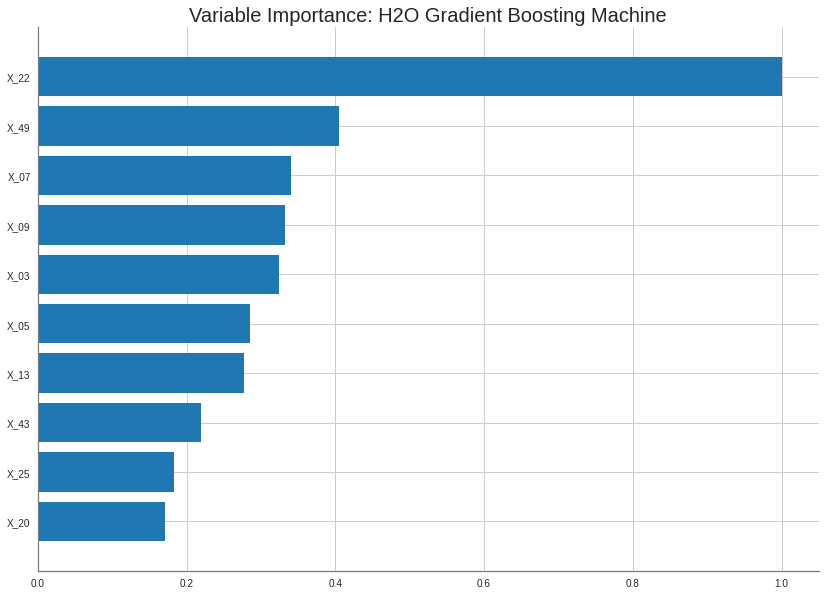

predict
1.14898
1.18533
1.07695
1.10737
1.06445
1.09879
1.12235
1.11003
1.09327
1.21665


Y_02
1.252
1.639
0.866
1.63
1.51
0.888
1.738
0.999
0.871
0.704


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_02'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred2 = aml.predict(h2o_test)
pred2

predict
1.20142
1.2151
1.14957
1.10302
1.03361
1.02837
1.02421
1.0543
1.02609
1.06831


In [ ]:
df = h2o_test.cbind(pred2)
res = df[:, ["predict"]]
res.set_names(['Y_02'])
h2o.export_file(res, path = "pred2.csv", force = True)


In [ ]:
df = h2o_test.cbind(pred2)
df.head(2)

X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,predict
68.504,103.321,76.67,101.867,73.963,30.51,63.57,239.8,0,0,4.37,0.15,13.38,13.4,13.5,13.53,13.46,3.27,3.32,3.18,3.39,2.22,2.14,2.31,2.16,2.32,2.22,1.38,1.53,1.33,1.53,12.96,12.95,12.97,12.88,-16.17,-16.17,-16.84,21.22,21.06,21.21,21.2,0.16,1469,17227.6,138.13,129.461,141.507,133.427,129.711,133.138,121.86,1.20142
67.485,103.32,69.37,101.992,67.845,28.03,116.99,189.23,0,0,4.36,0.17,13.35,13.38,13.45,13.52,13.44,3.26,3.3,3.17,3.34,2.11,2.1,2.1,2.1,2.17,2.2,1.36,1.56,1.34,1.55,12.94,12.89,13,12.88,-15.35,-15.25,-16.01,21.21,20.99,21.26,21.15,0.27,1462,17134.5,136.149,128.266,145.912,131.196,132.411,133.629,124.179,1.2151
69.524,103.32,68.97,101.884,77.022,29.65,205.68,214.93,0,0,4.43,0.2,13.32,13.35,13.4,13.52,13.41,3.07,3.12,3.05,3.17,2.13,2.1,2.29,2.15,2.24,2.26,1.5,1.69,1.47,1.71,12.93,12.9,13.02,13.01,-16.27,-16.35,-16.95,21.16,21.05,21.15,21.19,0.14,1469,14860.8,120.447,119.989,132.1,120.45,130.052,128.253,114.476,1.14957
69.524,103.32,65.87,101.866,73.963,28.15,103.38,180.8,0,0,4.39,0.18,13.32,13.34,13.45,13.5,13.42,3.23,3.11,3.2,3.14,2.1,2.1,2.09,2.09,2.1,2.18,1.49,1.65,1.46,1.9,12.99,12.98,12.91,12.96,-16.06,-16.13,-16.75,21.15,21.03,21.16,21.14,0.13,1469,15252.5,133.995,125.069,147.508,123.143,125.964,139.667,126.589,1.10302
73.603,103.321,66.67,101.891,74.983,29.92,71.2,231.93,0,0,4.38,0.12,13.38,13.39,13.45,13.5,13.46,3.17,3.2,3.04,3.2,2.12,2.11,2.1,2.1,2.12,2.18,1.48,1.73,1.46,1.67,13.01,12.84,12.99,13.01,-16.06,-16.17,-16.76,21.15,21.08,21.12,21.17,0.09,1469,10752.2,137.918,135.116,138.6,127.173,137.253,134.411,124.02,1.03361
65.445,103.32,62.97,101.879,69.884,29.26,61.35,223.55,0,0,4.39,0.14,13.35,13.38,13.44,13.49,13.44,3.19,3.15,3.08,3.13,2.14,2.11,2.12,2.12,2.14,2.19,1.49,1.65,1.48,1.66,12.94,12.98,12.99,12.9,-16.17,-16.26,-16.86,21.14,21.05,21.14,21.16,0.11,1469,12666.4,134.252,132.178,133.85,126.946,129.893,130.441,122.008,1.02837
68.504,103.32,59.17,103.133,68.864,28.79,64.46,231.59,0,0,4.37,0.14,13.35,13.36,13.41,13.49,13.43,3.17,3.11,3.18,3.12,2.09,2.08,2.05,2.07,2.09,2.15,1.48,1.67,1.48,1.83,12.97,12.89,12.96,12.93,-16.11,-16.11,-16.73,21.18,20.99,21.19,21.11,0.2,1460,11054.3,133.593,135.565,143.606,127.019,136.62,134.198,127.547,1.02421
67.485,103.32,67.67,101.988,76.002,29.89,93.78,243.87,0,0,4.34,0.15,13.36,13.36,13.41,13.51,13.45,3.08,3.12,3.03,3.06,2.08,2.06,2.06,2.09,2.12,2.18,1.5,1.68,1.46,2.1,12.96,12.87,12.88,12.87,-16.4,-16.38,-16.99,21.16,21.03,21.2,21.1,0.17,1467,11235.1,129.645,128.878,141.334,127.995,124.422,144.365,128.058,1.0543
68.504,103.32,63.87,101.926,70.904,28.9,54.58,227.12,0,0,4.38,0.15,13.36,13.37,13.45,13.51,13.44,3.23,3.13,3.08,3.2,2.12,2.09,2.1,2.11,2.13,2.18,1.47,1.64,1.46,1.64,13.01,13,12.97,12.85,-15.79,-15.85,-16.48,21.18,21.05,21.16,21.17,0.13,1469,11459.5,138.088,127.061,136.184,132.514,123.686,136.318,124.71,1.02609
70.544,103.32,63.87,101.92,71.923,28.27,105.86,225.68,0,0,4.37,0.12,13.37,13.39,13.39,13.49,13.43,3.29,3.25,3.22,3.1,2.11,2.05,2.16,2.13,2.33,2.13,1.48,1.69,1.45,1.99,12.96,12.85,13,12.95,-15.86,-15.9,-16.45,21.12,20.99,21.11,21.08,0.13,1469,12051,125.856,126.13,139.467,124.078,122.263,141.395,116.139,1.06831


In [ ]:
res = df[:, ["predict"]]
res.head(2)

predict
1.20142
1.2151


In [ ]:
res.set_names(['Y_02'])

Y_02
1.20142
1.2151
1.14957
1.10302
1.03361
1.02837
1.02421
1.0543
1.02609
1.06831


In [ ]:
h2o.export_file(res, 
                path = "pred2.csv", force = True)


In [52]:
preds = []
pred1 = h2o.import_file(path = "pred1.csv").as_data_frame()
pred2 = h2o.import_file(path = "pred2.csv").as_data_frame()
pred3 = h2o.import_file(path = "pred3.csv").as_data_frame()
pred4 = h2o.import_file(path = "pred4.csv").as_data_frame()
pred5 = h2o.import_file(path = "pred5.csv").as_data_frame()
pred6 = h2o.import_file(path = "pred6.csv").as_data_frame()
pred7 = h2o.import_file(path = "pred7.csv").as_data_frame()
pred8 = h2o.import_file(path = "pred8.csv").as_data_frame()
pred9 = h2o.import_file(path = "pred9.csv").as_data_frame()
pred10 = h2o.import_file(path = "pred10.csv").as_data_frame()
pred11 = h2o.import_file(path = "pred11.csv").as_data_frame()
pred12 = h2o.import_file(path = "pred12.csv").as_data_frame()
pred13 = h2o.import_file(path = "pred13.csv").as_data_frame()
pred14 = h2o.import_file(path = "pred14.csv").as_data_frame()
for i in range(1,15):
  preds.append(globals()['pred{0}'.format(i)])
len(preds)

14

In [44]:
preds[1]

Y_02
1.20142
1.2151
1.14957
1.10302
1.03361
1.02837
1.02421
1.0543
1.02609
1.06831


In [51]:
pred141 = pred14.as_data_frame()
pred141

,Y_14
0,-26.166948
1,-26.162430
2,-26.178548
3,-25.833714
4,-25.578032
...,...
39603,-26.379792
39604,-26.319365
39605,-26.573152
39606,-26.461453


In [59]:
for i, col in enumerate(sample_submission.columns):
    if col=='ID':
        continue
    sample_submission[col] = preds[i-1]

sample_submission.to_csv('answer.csv', index=False)

In [55]:
sample_submission

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,1.379516,1.201423,1.118374,13.650255,31.449284,16.105265,3.177910,-26.029897,-26.181427,-22.303352,24.288573,-26.134844,-26.187596,-26.166948
1,TEST_00002,1.492846,1.215100,1.116803,13.521275,30.258066,16.692413,3.161556,-26.157916,-26.281400,-22.322309,24.490435,-26.138319,-26.120663,-26.162430
2,TEST_00003,1.404450,1.149574,1.044079,15.042037,32.164497,16.842150,3.076973,-25.861232,-25.936368,-22.174618,24.692893,-25.741087,-25.831071,-26.178548
3,TEST_00004,1.421545,1.103023,1.050518,14.681419,31.992427,16.855642,3.037427,-25.638748,-25.720759,-21.825884,24.849988,-25.705240,-25.674980,-25.833714
4,TEST_00005,1.412104,1.033608,0.950556,14.500263,31.116072,16.820697,2.994493,-25.574882,-25.802942,-21.967586,24.425086,-25.707663,-25.797368,-25.578032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,1.280007,0.994241,0.978048,13.215557,31.690190,16.587252,3.151847,-26.420952,-26.337468,-22.954407,24.361641,-26.473679,-26.396178,-26.379792
39604,TEST_39605,1.197604,0.902849,1.020681,13.993592,31.470597,16.773484,3.114155,-26.342682,-26.287164,-22.553039,24.512224,-26.285964,-26.426966,-26.319365
39605,TEST_39606,1.236134,0.931532,1.013079,13.732950,31.511894,16.635863,3.166769,-26.524982,-26.429206,-22.864653,24.493761,-26.432615,-26.348341,-26.573152
39606,TEST_39607,1.237447,0.880357,0.926702,14.638755,31.468513,16.821471,3.231675,-26.487126,-26.414698,-22.763758,24.523799,-26.370676,-26.419504,-26.461453


In [45]:
for i, col in enumerate(sample_submission.columns):
  print(i, col)

0 ID
1 Y_01
2 Y_02
3 Y_03
4 Y_04
5 Y_05
6 Y_06
7 Y_07
8 Y_08
9 Y_09
10 Y_10
11 Y_11
12 Y_12
13 Y_13
14 Y_14


In [ ]:
# 모델 저장
import pickle

with open('Y_02.pkl', 'wb') as f:
 pickle.dump(pred2, f)

##### 3번

In [13]:
# 1시간
train_3 = train3.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_3, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_3.columns)
y = "Y_03"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_2_20220810_54009_model_11,0.357687,0.12794,0.280067,0.179515,0.12794
GBM_grid_1_AutoML_2_20220810_54009_model_3,0.357839,0.128049,0.280241,0.179683,0.128049
GBM_grid_1_AutoML_2_20220810_54009_model_1,0.357904,0.128095,0.280143,0.1797,0.128095
GBM_2_AutoML_2_20220810_54009,0.357934,0.128117,0.280272,0.179699,0.128117
GBM_1_AutoML_2_20220810_54009,0.357979,0.128149,0.28085,0.179672,0.128149
GBM_grid_1_AutoML_2_20220810_54009_model_19,0.358004,0.128167,0.280353,0.179787,0.128167
GBM_grid_1_AutoML_2_20220810_54009_model_7,0.358051,0.1282,0.280029,0.17971,0.1282
GBM_5_AutoML_2_20220810_54009,0.35809,0.128229,0.280805,0.179796,0.128229
GBM_grid_1_AutoML_2_20220810_54009_model_13,0.358128,0.128255,0.280388,0.179795,0.128255
GBM_grid_1_AutoML_2_20220810_54009_model_6,0.358182,0.128294,0.280658,0.179822,0.128294


In [14]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.12794021101686553
RMSE: 0.35768730899609164
MAE: 0.28006660142653883
RMSLE: 0.17951524593490867
Mean Residual Deviance: 0.12794021101686553


[('X_22', 118.40201568603516, 1.0, 0.05255923521110529), ('X_19', 117.94013214111328, 0.9960990229579652, 0.052354202841199855), ('X_03', 106.7720718383789, 0.9017757951140359, 0.0473966461230801), ('X_49', 103.02698516845703, 0.8701455340224287, 0.04573418379057764), ('X_18', 89.04830169677734, 0.752084338943227, 0.0395289776691057), ('X_13', 85.84581756591797, 0.7250367915488367, 0.038107379263720424), ('X_07', 78.9417724609375, 0.6667265924785116, 0.035042639795576834), ('X_05', 76.9691162109375, 0.650065928058483, 0.034166968015551254), ('X_45', 74.7269058227539, 0.6311286627155581, 0.033171639832137355), ('X_43', 73.31259155273438, 0.6191836441968713, 0.03254381879421269), ('X_09', 72.46098327636719, 0.6119911291756289, 0.0321657857054518), ('X_20', 66.419921875, 0.5609695197345687, 0.02948412893398996), ('X_21', 59.39556884765625, 0.5016432237535093, 0.026365984189317813), ('X_52', 55.57349395751953, 0.469362735385206, 0.024669346408438812), ('X_51', 52.233863830566406, 0.4411568

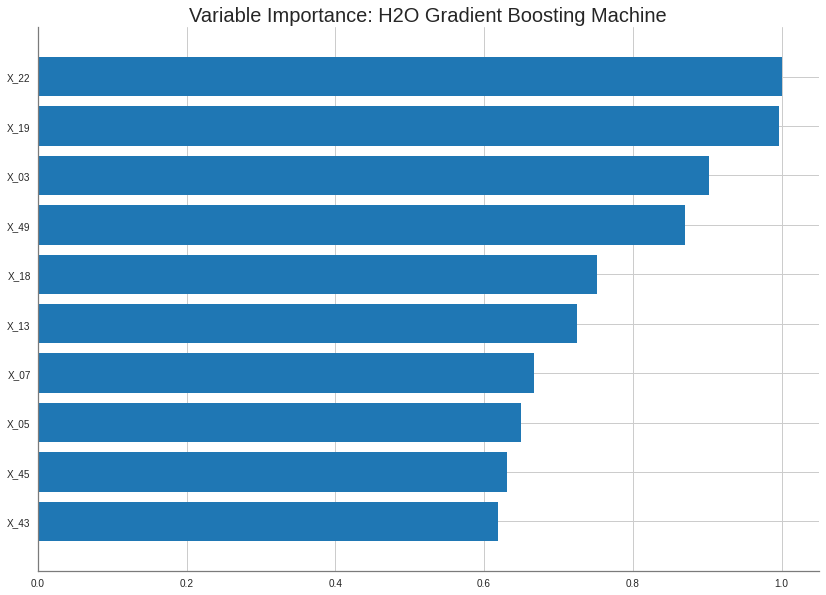

predict
0.960344
1.08647
1.00779
1.01552
1.00846
1.11221
0.963182
0.913523
1.06372
0.940426


Y_03
0.971
0.791
1.18
1.275
0.966
1.494
1.284
0.835
1.099
0.8


<Figure size 432x288 with 0 Axes>

In [15]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_03'])

In [16]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred3 = aml.predict(h2o_test)
pred3

predict
1.11837
1.1168
1.04408
1.05052
0.950556
0.949911
1.0249
0.972827
0.990747
1.0331


In [17]:
df = h2o_test.cbind(pred3)
res = df[:, ["predict"]]
res.set_names(['Y_03'])
h2o.export_file(res, path = "pred3.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_03.pkl', 'wb') as f:
 pickle.dump(pred3, f)

##### 4

In [18]:
# 1시간
train_4 = train4.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_4, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_4.columns)
y = "Y_04"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_3_20220810_71100,2.68546,7.21169,2.10188,0.195733,7.21169
GBM_grid_1_AutoML_3_20220810_71100_model_4,2.68674,7.21855,2.09962,0.195917,7.21855
GBM_grid_1_AutoML_3_20220810_71100_model_1,2.69001,7.23616,2.10187,0.196173,7.23616
GBM_grid_1_AutoML_3_20220810_71100_model_12,2.69104,7.2417,2.10525,0.196268,7.2417
GBM_grid_1_AutoML_3_20220810_71100_model_8,2.69182,7.24588,2.10674,0.196311,7.24588
GBM_2_AutoML_3_20220810_71100,2.69267,7.25047,2.10981,0.196363,7.25047
GBM_grid_1_AutoML_3_20220810_71100_model_3,2.69274,7.25086,2.10664,0.196357,7.25086
GBM_3_AutoML_3_20220810_71100,2.69386,7.25687,2.10242,0.196274,7.25687
XRT_1_AutoML_3_20220810_71100,2.69427,7.2591,2.10744,0.196218,7.2591
DRF_1_AutoML_3_20220810_71100,2.69565,7.26654,2.10714,0.196336,7.26654


In [19]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 7.211692317111663
RMSE: 2.6854594238438354
MAE: 2.1018833926776894
RMSLE: 0.19573306349736794
Mean Residual Deviance: 7.211692317111663


[('X_03', 13782.078125, 1.0, 0.05899637566218778), ('X_32', 13160.8076171875, 0.9549218556027812, 0.05633692852117511), ('X_09', 8635.001953125, 0.6265384563059135, 0.0369634981350309), ('X_19', 8000.70556640625, 0.5805151802102595, 0.0342482916492871), ('X_07', 7516.9560546875, 0.5454152840022085, 0.03217752498689313), ('X_51', 7162.19384765625, 0.5196744484174988, 0.03065890898087898), ('X_20', 6842.30517578125, 0.4964639667344253, 0.02928957468420405), ('X_13', 6399.99462890625, 0.46437079886356036, 0.027396194096304848), ('X_22', 6244.6455078125, 0.4530989776124564, 0.02673119749537769), ('X_21', 6201.59228515625, 0.44997512195979156, 0.02654690133377862), ('X_49', 5989.4130859375, 0.4345798240015056, 0.025638634552000272), ('X_30', 5804.85693359375, 0.4211887990290833, 0.02484861261222551), ('X_05', 5389.544921875, 0.3910545908239074, 0.023070803544670372), ('X_37', 5383.23681640625, 0.3905968873185625, 0.02304380069672714), ('X_54', 5324.26611328125, 0.3863180911464504, 0.0227913

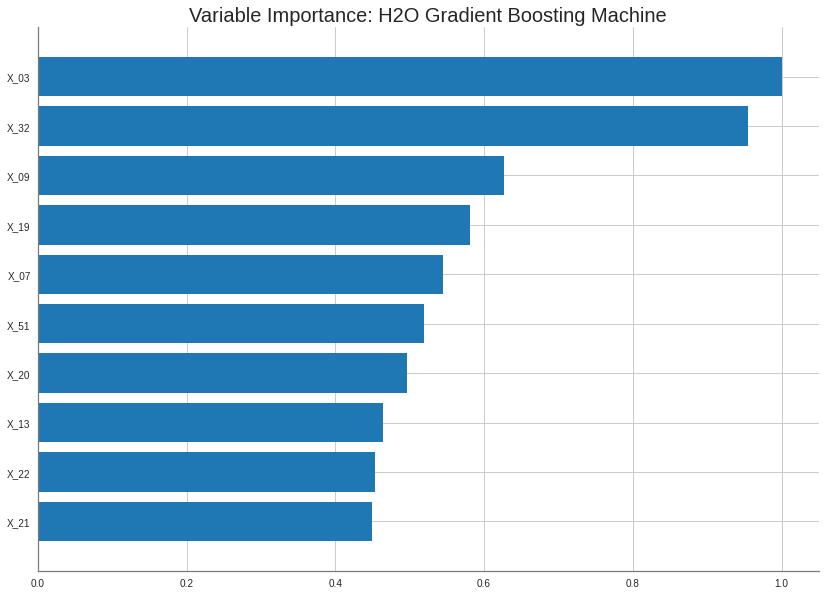

predict
13.7813
13.3316
13.5706
13.2385
12.9199
13.6647
13.3118
13.0764
14.8411
14.8322


Y_04
11.355
14.553
17.256
11.235
14.904
13.04
17.715
8.346
16.978
14.912


<Figure size 432x288 with 0 Axes>

In [20]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_04'])

In [21]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred4 = aml.predict(h2o_test)
pred4

predict
13.6503
13.5213
15.042
14.6814
14.5003
15.3641
15.5395
14.093
15.3125
15.6274


In [22]:
df = h2o_test.cbind(pred4)
res = df[:, ["predict"]]
res.set_names(['Y_04'])
h2o.export_file(res, path = "pred4.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_04.pkl', 'wb') as f:
 pickle.dump(pred4, f)

##### 5 

In [23]:
# 1시간
train_5 = train5.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_5, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_5.columns)
y = "Y_05"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_4_20220810_82743_model_8,2.51156,6.30791,1.99964,0.0811132,6.30791
GBM_grid_1_AutoML_4_20220810_82743_model_7,2.51193,6.30979,2.00069,0.0811383,6.30979
GBM_grid_1_AutoML_4_20220810_82743_model_1,2.51514,6.32595,1.99982,0.0812473,6.32595
GBM_1_AutoML_4_20220810_82743,2.5166,6.33328,2.00301,0.0812687,6.33328
GBM_grid_1_AutoML_4_20220810_82743_model_24,2.51701,6.33536,2.00627,0.0812979,6.33536
GBM_grid_1_AutoML_4_20220810_82743_model_11,2.51743,6.33743,2.00128,0.0813058,6.33743
GBM_grid_1_AutoML_4_20220810_82743_model_21,2.51747,6.33766,2.00572,0.0812939,6.33766
GBM_grid_1_AutoML_4_20220810_82743_model_9,2.51862,6.34344,2.0076,0.0813377,6.34344
GBM_grid_1_AutoML_4_20220810_82743_model_12,2.51876,6.34417,2.00584,0.0813594,6.34417
GBM_grid_1_AutoML_4_20220810_82743_model_14,2.51967,6.34873,2.00608,0.0813675,6.34873


In [24]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 6.307914423094385
RMSE: 2.5115561755800693
MAE: 1.9996414821674897
RMSLE: 0.08111316469002985
Mean Residual Deviance: 6.307914423094385


[('X_03', 7216.47412109375, 1.0, 0.04309090971793266), ('X_09', 6601.04296875, 0.9147185811219297, 0.03941605579644054), ('X_49', 6559.294921875, 0.9089334780127852, 0.03916677044065547), ('X_13', 5936.6630859375, 0.8226542472569308, 0.03544891989762226), ('X_51', 5290.69580078125, 0.7331413806801509, 0.03159172904536888), ('X_19', 4980.49755859375, 0.6901566436766895, 0.029739477623903648), ('X_35', 4824.92333984375, 0.6685984400249565, 0.028810515016666014), ('X_12', 4699.34619140625, 0.6511969851966992, 0.0280606704977009), ('X_17', 4554.6806640625, 0.631150418838082, 0.02719684571658718), ('X_05', 4507.9658203125, 0.624677057614011, 0.02691790269250917), ('X_56', 4395.53173828125, 0.609096861503752, 0.02624653786853431), ('X_54', 4349.24169921875, 0.6026823662411425, 0.0259701314322871), ('X_21', 4334.98193359375, 0.6007063644727277, 0.025884983718481865), ('X_37', 4332.55908203125, 0.6003706255063234, 0.02587051642099174), ('X_07', 4327.3486328125, 0.5996486040410873, 0.0258394038

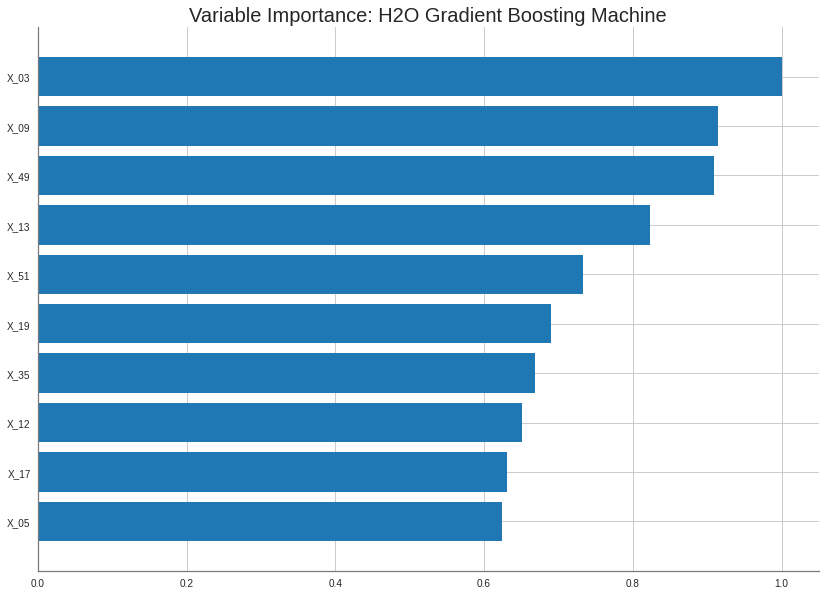

predict
31.5366
31.4835
31.6647
30.9059
31.5464
31.0197
31.2655
31.8676
31.6824
31.1704


Y_05
31.864
34.227
29.032
28.887
27.221
32.174
26.465
30.399
34.768
30.046


<Figure size 432x288 with 0 Axes>

In [25]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_05'])

In [26]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred5 = aml.predict(h2o_test)
pred5

predict
31.4493
30.2581
32.1645
31.9924
31.1161
32.3031
31.7432
31.2334
31.8503
30.9095


In [27]:
df = h2o_test.cbind(pred5)
res = df[:, ["predict"]]
res.set_names(['Y_05'])
h2o.export_file(res, path = "pred5.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_05.pkl', 'wb') as f:
 pickle.dump(pred5, f)

##### 6

In [28]:
# 1시간
train_6 = train6.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_6, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_6.columns)
y = "Y_06"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_5_20220810_101648_model_109,1.62905,2.65381,0.730334,nan,2.65381
GBM_grid_1_AutoML_5_20220810_101648_model_115,1.63315,2.66718,0.740361,nan,2.66718
GBM_grid_1_AutoML_5_20220810_101648_model_86,1.63667,2.67869,0.732419,nan,2.67869
GBM_grid_1_AutoML_5_20220810_101648_model_62,1.64244,2.69762,0.739954,nan,2.69762
GBM_grid_1_AutoML_5_20220810_101648_model_106,1.64297,2.69934,0.731172,nan,2.69934
GBM_grid_1_AutoML_5_20220810_101648_model_1,1.64337,2.70066,0.72714,nan,2.70066
GBM_grid_1_AutoML_5_20220810_101648_model_47,1.64419,2.70335,0.732629,nan,2.70335
GBM_grid_1_AutoML_5_20220810_101648_model_100,1.64445,2.70422,0.735539,nan,2.70422
GBM_grid_1_AutoML_5_20220810_101648_model_81,1.64781,2.71528,0.732772,nan,2.71528
GBM_grid_1_AutoML_5_20220810_101648_model_92,1.64836,2.71711,0.727702,nan,2.71711


In [29]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 2.6538105531111045
RMSE: 1.6290520412531653
MAE: 0.7303341535876917
RMSLE: NaN
Mean Residual Deviance: 2.6538105531111045


[('X_49', 43974.328125, 1.0, 0.15850325942506568), ('X_09', 22793.92578125, 0.518346197728291, 0.0821595618505237), ('X_07', 21654.3984375, 0.4924327297496373, 0.07805219271290002), ('X_19', 18142.51953125, 0.41257070442733457, 0.0653938013950279), ('X_05', 17011.962890625, 0.3868612350885122, 0.06131876670673578), ('X_03', 15733.03515625, 0.3577777268484418, 0.05670893585516885), ('X_54', 8372.083984375, 0.19038571687955722, 0.030176756673387563), ('X_21', 7092.7314453125, 0.16129254835118642, 0.025565394634638052), ('X_35', 6422.72265625, 0.14605618619101984, 0.02315038157047091), ('X_20', 6278.4853515625, 0.14277615188833542, 0.02263048544246941), ('X_42', 6255.35205078125, 0.14225008811959536, 0.022547102620458673), ('X_33', 5128.16015625, 0.11661713492637928, 0.01848419599064378), ('X_56', 5121.759765625, 0.11647158658265458, 0.0184611261037595), ('X_22', 4712.3798828125, 0.10716206668166121, 0.016985536855769534), ('X_06', 4671.12548828125, 0.10622391944234509, 0.0168368374605173

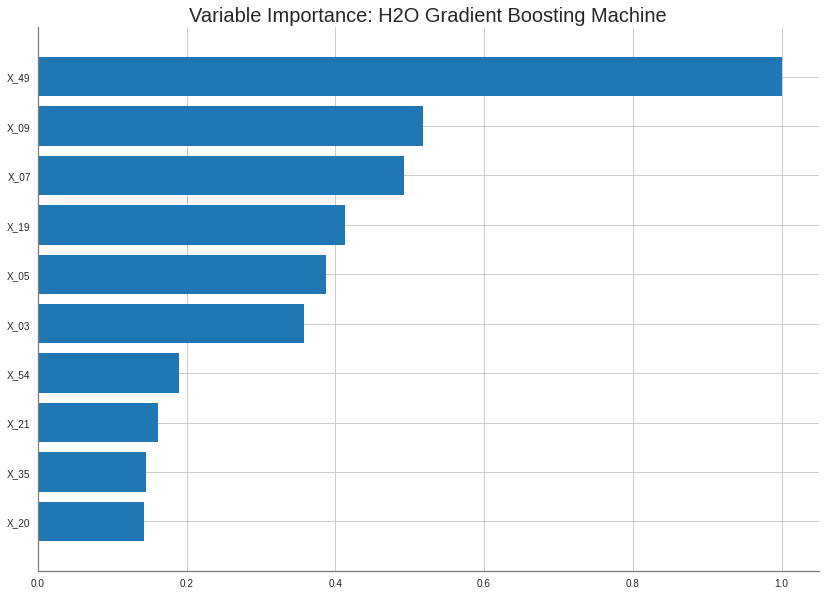

predict
16.6427
16.6815
16.8258
16.6865
16.4214
16.7783
16.3571
16.6921
16.7149
16.9255


Y_06
15.817
16.454
14.925
17.605
15.6
16.451
16.089
17.362
15.967
17.297


<Figure size 432x288 with 0 Axes>

In [30]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_06'])

In [31]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred6 = aml.predict(h2o_test)
pred6

predict
16.1053
16.6924
16.8422
16.8556
16.8207
16.9062
16.9376
17.2465
16.9079
16.983


In [32]:
df = h2o_test.cbind(pred6)
res = df[:, ["predict"]]
res.set_names(['Y_06'])
h2o.export_file(res, path = "pred6.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_06.pkl', 'wb') as f:
 pickle.dump(pred6, f)

##### 7

In [ ]:
# 1시간
train_7 = train7.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_7, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_7.columns)
y = "Y_07"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_1_20220809_50309,0.4106,0.168592,0.326688,0.100534,0.168592
GBM_grid_1_AutoML_1_20220809_50309_model_10,0.411957,0.169708,0.327658,0.10085,0.169708
GBM_grid_1_AutoML_1_20220809_50309_model_11,0.411971,0.16972,0.327472,0.100881,0.16972
GBM_grid_1_AutoML_1_20220809_50309_model_16,0.412169,0.169883,0.327463,0.100952,0.169883
GBM_grid_1_AutoML_1_20220809_50309_model_13,0.412245,0.169946,0.327741,0.100977,0.169946
GBM_2_AutoML_1_20220809_50309,0.412274,0.16997,0.327654,0.10093,0.16997
GBM_grid_1_AutoML_1_20220809_50309_model_1,0.412358,0.170039,0.327877,0.100972,0.170039
GBM_5_AutoML_1_20220809_50309,0.412469,0.170131,0.327689,0.101004,0.170131
DeepLearning_grid_1_AutoML_1_20220809_50309_model_8,0.412477,0.170137,0.327332,0.101174,0.170137
GBM_grid_1_AutoML_1_20220809_50309_model_2,0.412566,0.170211,0.328104,0.101073,0.170211


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.1685921803917869
RMSE: 0.41059978128560526
MAE: 0.3266881824191429
RMSLE: 0.10053355216631056
Mean Residual Deviance: 0.1685921803917869


[('X_19', 232.0760498046875, 1.0, 0.04991783148996076), ('X_03', 198.2276153564453, 0.8541493856142043, 0.04263728509834337), ('X_21', 178.04205322265625, 0.7671711638167504, 0.03829552087936163), ('X_13', 168.6159210205078, 0.7265545977812575, 0.036268029980301035), ('X_22', 141.6387176513672, 0.6103116533160948, 0.030465434266592175), ('X_09', 135.7854766845703, 0.5850904339282136, 0.029206445687216587), ('X_49', 127.90279388427734, 0.5511244869598515, 0.027510939270052947), ('X_36', 125.1009750366211, 0.539051639072212, 0.026908288883593826), ('X_17', 120.12631225585938, 0.517616153657201, 0.025838275934741802), ('X_37', 119.82461547851562, 0.5163161626516766, 0.025773383202789563), ('X_05', 119.71019744873047, 0.5158231431010531, 0.02574877273594029), ('X_35', 116.41703796386719, 0.5016331416440534, 0.025040438634367477), ('X_07', 113.3650131225586, 0.48848217305476055, 0.024383970800397392), ('X_12', 112.1663589477539, 0.48331725329757985, 0.024126149206299276), ('X_01', 111.77460

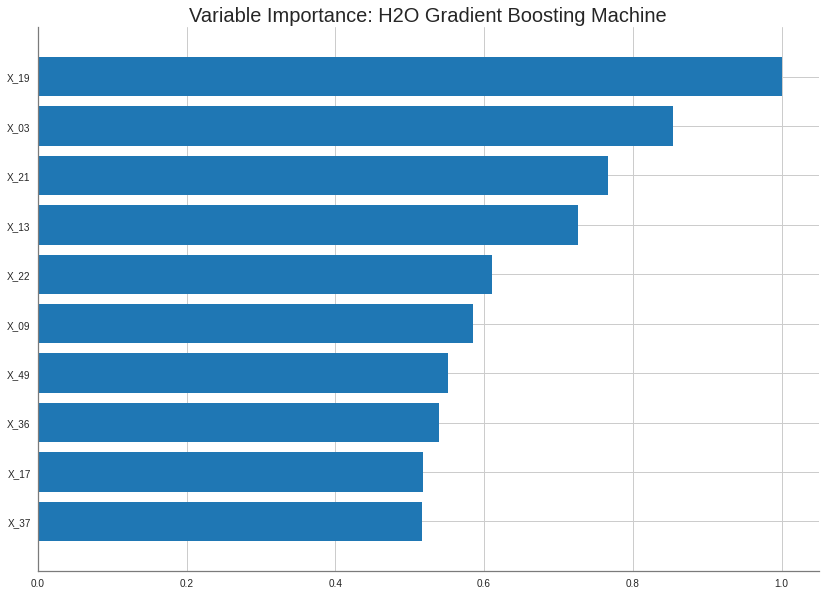

predict
3.18933
3.07135
3.1027
3.20774
3.34341
3.1997
3.18616
3.13507
3.19752
3.31613


Y_07
3.664
3.168
3.153
2.976
3.079
3.479
2.988
2.808
3.505
2.348


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_07'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred7 = aml.predict(h2o_test)
pred7

predict
3.17791
3.16156
3.07697
3.03743
2.99449
3.09741
3.07448
3.13047
3.06537
3.07061


In [ ]:
df = h2o_test.cbind(pred7)
res = df[:, ["predict"]]
res.set_names(['Y_07'])
h2o.export_file(res, path = "pred7.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_07.pkl', 'wb') as f:
 pickle.dump(pred7, f)

##### 8

In [ ]:
# 1시간
train_8 = train8.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_8, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_8.columns)
y = "Y_08"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_2_20220809_60429,0.621314,0.386031,0.483777,nan,0.386031
GBM_grid_1_AutoML_2_20220809_60429_model_17,0.621772,0.386601,0.483796,nan,0.386601
GBM_3_AutoML_2_20220809_60429,0.621777,0.386607,0.484638,nan,0.386607
GBM_2_AutoML_2_20220809_60429,0.622002,0.386887,0.483902,nan,0.386887
GBM_grid_1_AutoML_2_20220809_60429_model_20,0.622383,0.38736,0.484151,nan,0.38736
GBM_grid_1_AutoML_2_20220809_60429_model_14,0.622429,0.387417,0.483734,nan,0.387417
GBM_5_AutoML_2_20220809_60429,0.622803,0.387883,0.484354,nan,0.387883
GBM_grid_1_AutoML_2_20220809_60429_model_22,0.623177,0.388349,0.485207,nan,0.388349
GBM_grid_1_AutoML_2_20220809_60429_model_4,0.623225,0.388409,0.485127,nan,0.388409
GBM_grid_1_AutoML_2_20220809_60429_model_1,0.623365,0.388584,0.484982,nan,0.388584


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.3860310948688136
RMSE: 0.6213140066575142
MAE: 0.4837774484306609
RMSLE: NaN
Mean Residual Deviance: 0.3860310948688136


[('X_20', 1263.974365234375, 1.0, 0.0872980842126717), ('X_32', 743.7327880859375, 0.5884081264164162, 0.05136690217132067), ('X_49', 688.6318359375, 0.5448147168790161, 0.047561281034407224), ('X_07', 624.4029541015625, 0.4939996975221735, 0.04312522719532504), ('X_03', 509.6675720214844, 0.40322619353674805, 0.03520087420012609), ('X_22', 504.613037109375, 0.3992272715244554, 0.034851775969537056), ('X_30', 486.1494140625, 0.3846196785583976, 0.03357656108864172), ('X_05', 397.49981689453125, 0.3144840811869029, 0.027453857802998933), ('X_09', 364.3586730957031, 0.28826429009748245, 0.025164920272436046), ('X_08', 363.10601806640625, 0.28727324544993965, 0.025078403973336334), ('X_19', 346.777099609375, 0.27435453530346965, 0.023950625327050706), ('X_45', 327.85467529296875, 0.2593839592879525, 0.022643722721335885), ('X_01', 306.5500793457031, 0.24252871559532022, 0.021172292238031368), ('X_21', 301.4706726074219, 0.23851011610628753, 0.02082147620142079), ('X_54', 296.4170532226562

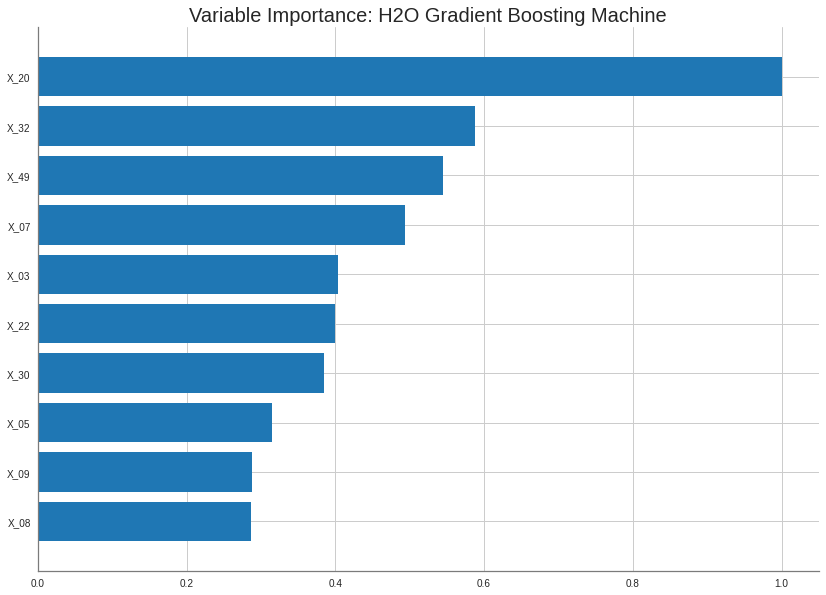

predict
-26.3569
-26.4803
-26.3452
-26.2019
-26.3523
-26.3054
-26.1808
-26.553
-26.3656
-26.1725


Y_08
-25.65
-27.354
-26.19
-26.565
-25.509
-26.019
-27.088
-25.755
-26.634
-27.214


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_08'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred8 = aml.predict(h2o_test)
pred8

predict
-26.0299
-26.1579
-25.8612
-25.6387
-25.5749
-25.5955
-25.7904
-25.6851
-25.7148
-25.7694


In [ ]:
df = h2o_test.cbind(pred8)
res = df[:, ["predict"]]
res.set_names(['Y_08'])
h2o.export_file(res, path = "pred8.csv", force = True)


In [ ]:
# 모델 저장
import pickle

with open('Y_08.pkl', 'wb') as f:
 pickle.dump(pred8, f)

##### 9

In [ ]:
# 1시간
train_9 = train9.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_9, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_9.columns)
y = "Y_09"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_3_20220809_70516_model_12,0.628936,0.395561,0.488499,nan,0.395561
GBM_grid_1_AutoML_3_20220809_70516_model_1,0.629782,0.396625,0.489482,nan,0.396625
GBM_grid_1_AutoML_3_20220809_70516_model_6,0.630159,0.3971,0.489087,nan,0.3971
GBM_4_AutoML_3_20220809_70516,0.630936,0.39808,0.49015,nan,0.39808
GBM_grid_1_AutoML_3_20220809_70516_model_3,0.631002,0.398164,0.489383,nan,0.398164
GBM_1_AutoML_3_20220809_70516,0.631142,0.39834,0.489709,nan,0.39834
GBM_2_AutoML_3_20220809_70516,0.631222,0.398441,0.489617,nan,0.398441
GBM_grid_1_AutoML_3_20220809_70516_model_4,0.631357,0.398612,0.490013,nan,0.398612
GBM_grid_1_AutoML_3_20220809_70516_model_16,0.631435,0.39871,0.490175,nan,0.39871
GBM_grid_1_AutoML_3_20220809_70516_model_15,0.631619,0.398942,0.490722,nan,0.398942


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.3955607488716556
RMSE: 0.628936204134931
MAE: 0.4884992237447812
RMSLE: NaN
Mean Residual Deviance: 0.3955607488716556


[('X_20', 927.473876953125, 1.0, 0.06882584294830685), ('X_49', 737.4815673828125, 0.7951507699661984, 0.054726922013918836), ('X_07', 656.5462036132812, 0.7078864644361983, 0.04872088262651798), ('X_32', 619.1046752929688, 0.66751710282861, 0.045942427284590706), ('X_03', 537.7140502929688, 0.5797619357856535, 0.03990260393978975), ('X_08', 505.3442687988281, 0.5448609188422118, 0.03750051202890423), ('X_21', 498.88677978515625, 0.5378984704389365, 0.03702131564856471), ('X_22', 462.1579284667969, 0.4982975153812926, 0.03429574653516436), ('X_30', 387.9615783691406, 0.41829919743254224, 0.02878979486789495), ('X_09', 329.92169189453125, 0.3557207379019319, 0.024482779640294192), ('X_05', 328.71075439453125, 0.35441510813694266, 0.024392918571140405), ('X_45', 308.2239990234375, 0.3323263400539046, 0.022872640488135653), ('X_53', 285.8775939941406, 0.30823250238948674, 0.02121436180102243), ('X_41', 277.00836181640625, 0.2986697185762423, 0.02055619514414346), ('X_25', 266.919281005859

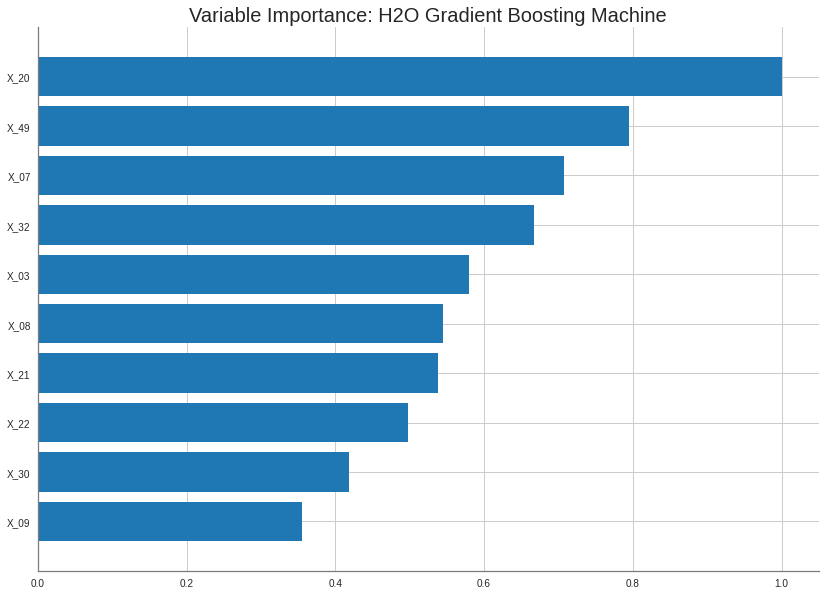

predict
-26.2312
-26.5157
-26.5823
-26.0943
-26.2764
-26.3092
-26.6201
-25.9768
-26.2665
-26.6037


Y_09
-28.488
-26.542
-27.229
-25.725
-27.709
-25.612
-26.851
-25.512
-26.385
-26.284


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_09'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred9 = aml.predict(h2o_test)
pred9

predict
-26.1814
-26.2814
-25.9364
-25.7208
-25.8029
-25.7322
-25.8496
-25.6846
-25.7189
-25.9259


In [ ]:
# 모델 저장
import pickle

with open('Y_09.pkl', 'wb') as f:
 pickle.dump(pred9, f)

In [ ]:
df = h2o_test.cbind(pred9)
res = df[:, ["predict"]]
res.set_names(['Y_09'])
h2o.export_file(res, path = "pred9.csv", force = True)


##### 10

In [ ]:
# 1시간
train_10 = train10.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_10, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_10.columns)
y = "Y_10"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_4_20220809_81409_model_22,0.851686,0.725368,0.629048,nan,0.725368
GBM_3_AutoML_4_20220809_81409,0.852587,0.726905,0.631044,nan,0.726905
GBM_grid_1_AutoML_4_20220809_81409_model_14,0.853023,0.727648,0.629375,nan,0.727648
GBM_grid_1_AutoML_4_20220809_81409_model_25,0.853412,0.728312,0.633709,nan,0.728312
GBM_grid_1_AutoML_4_20220809_81409_model_24,0.853601,0.728635,0.630862,nan,0.728635
GBM_1_AutoML_4_20220809_81409,0.854787,0.73066,0.63153,nan,0.73066
GBM_grid_1_AutoML_4_20220809_81409_model_38,0.854922,0.730892,0.630811,nan,0.730892
GBM_grid_1_AutoML_4_20220809_81409_model_7,0.854928,0.730902,0.631529,nan,0.730902
GBM_grid_1_AutoML_4_20220809_81409_model_27,0.85519,0.73135,0.630677,nan,0.73135
GBM_grid_1_AutoML_4_20220809_81409_model_1,0.855261,0.731472,0.629772,nan,0.731472


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.7253683090383369
RMSE: 0.8516855693495909
MAE: 0.6290482252871222
RMSLE: NaN
Mean Residual Deviance: 0.7253683090383369


[('X_49', 3134.7998046875, 1.0, 0.07948300330412396), ('X_07', 2948.859375, 0.9406850704120049, 0.07476847455969746), ('X_03', 2191.799560546875, 0.6991832643569307, 0.055573185711070096), ('X_09', 1758.356689453125, 0.5609151457850148, 0.044583220385763504), ('X_08', 1624.4989013671875, 0.5182145599658571, 0.04118924958201136), ('X_21', 1605.2633056640625, 0.512078411917627, 0.0407015301064193), ('X_19', 1480.874755859375, 0.47239850967357055, 0.03754765230524764), ('X_18', 1375.6265869140625, 0.4388243819771436, 0.03487907980261945), ('X_05', 1273.090087890625, 0.4061152760016635, 0.032279261824295434), ('X_22', 1118.9237060546875, 0.35693625614673985, 0.028370365626672958), ('X_20', 886.2080078125, 0.2827000328656853, 0.022469847646339212), ('X_54', 785.3184814453125, 0.25051631056982243, 0.019911788740758142), ('X_14', 773.9359130859375, 0.24688527539419353, 0.019623183159896238), ('X_44', 734.2984619140625, 0.23424094285576325, 0.01861817363496574), ('X_06', 698.827880859375, 0.22

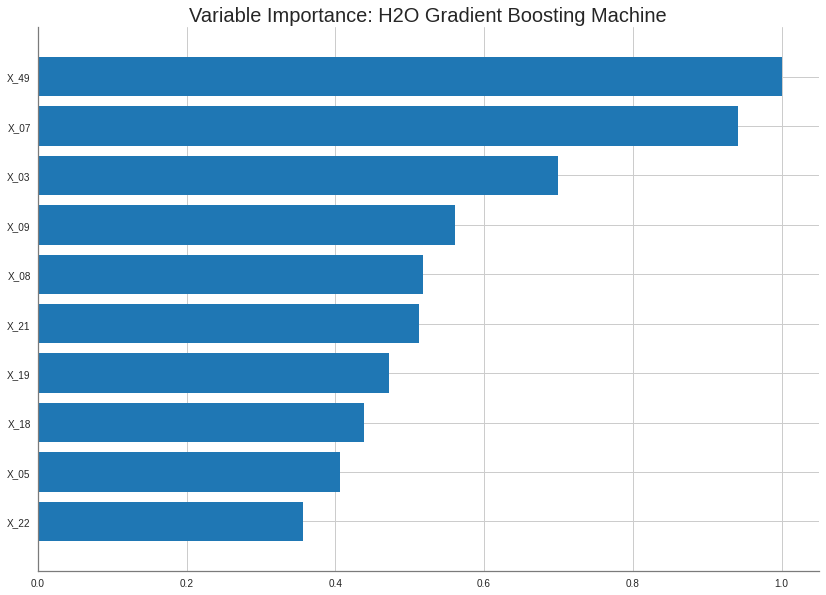

predict
-22.379
-22.3151
-22.3532
-22.2567
-22.4254
-22.0326
-22.1427
-22.0043
-22.3453
-22.0742


Y_10
-22.924
-22.275
-23.672
-21.553
-22.74
-22.641
-22.61
-21.596
-22.219
-21.63


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_10'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred10 = aml.predict(h2o_test)
pred10

predict
-22.3034
-22.3223
-22.1746
-21.8259
-21.9676
-21.975
-21.864
-22.1207
-21.9159
-22.0982


In [ ]:
# 모델 저장
import pickle

with open('Y_10.pkl', 'wb') as f:
 pickle.dump(pred10, f)

In [ ]:
df = h2o_test.cbind(pred10)
res = df[:, ["predict"]]
res.set_names(['Y_10'])
h2o.export_file(res, path = "pred10.csv", force = True)


##### 11

In [ ]:
# 1시간
train_11 = train11.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_11, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_11.columns)
y = "Y_11"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_5_20220809_91420,0.809108,0.654656,0.636643,0.0323525,0.654656
GBM_grid_1_AutoML_5_20220809_91420_model_10,0.809792,0.655763,0.636743,0.0323795,0.655763
GBM_3_AutoML_5_20220809_91420,0.810514,0.656933,0.637333,0.0324093,0.656933
GBM_2_AutoML_5_20220809_91420,0.810866,0.657503,0.637463,0.0324225,0.657503
GBM_grid_1_AutoML_5_20220809_91420_model_9,0.812096,0.6595,0.638594,0.0324718,0.6595
DeepLearning_grid_1_AutoML_5_20220809_91420_model_5,0.812908,0.66082,0.638272,0.032504,0.66082
GBM_5_AutoML_5_20220809_91420,0.813122,0.661167,0.639492,0.0325116,0.661167
GBM_grid_1_AutoML_5_20220809_91420_model_22,0.813211,0.661312,0.639367,0.0325132,0.661312
GBM_grid_1_AutoML_5_20220809_91420_model_16,0.813293,0.661445,0.639368,0.0325208,0.661445
XRT_1_AutoML_5_20220809_91420,0.813434,0.661676,0.639885,0.0325147,0.661676


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.6546561223934642
RMSE: 0.8091082266257489
MAE: 0.6366431890718313
RMSLE: 0.03235247985212805
Mean Residual Deviance: 0.6546561223934642


[('X_49', 1131.2080078125, 1.0, 0.055620740359036205), ('X_03', 979.998779296875, 0.866329421758577, 0.048185883833027784), ('X_09', 776.0658569335938, 0.6860505332121272, 0.03815863858097007), ('X_05', 722.041259765625, 0.638292210432535, 0.03550228530966333), ('X_35', 556.4392700195312, 0.49189827704239714, 0.02735974635043243), ('X_17', 545.025146484375, 0.48180806953296784, 0.026798521538381664), ('X_08', 532.5529174804688, 0.4707824854513764, 0.026185270388872747), ('X_01', 531.673095703125, 0.47000471357275864, 0.02614201014115359), ('X_06', 519.588134765625, 0.4593214786115161, 0.02554780070317974), ('X_21', 503.47943115234375, 0.445081212009769, 0.024755746531880507), ('X_20', 495.00079345703125, 0.4375860054370112, 0.024338857593159804), ('X_51', 483.53143310546875, 0.42744696799000653, 0.02377491682382941), ('X_54', 478.9062805175781, 0.4233582835429837, 0.02354750116779153), ('X_19', 467.5931091308594, 0.4133573188144933, 0.02299124010528828), ('X_37', 465.58099365234375, 0.

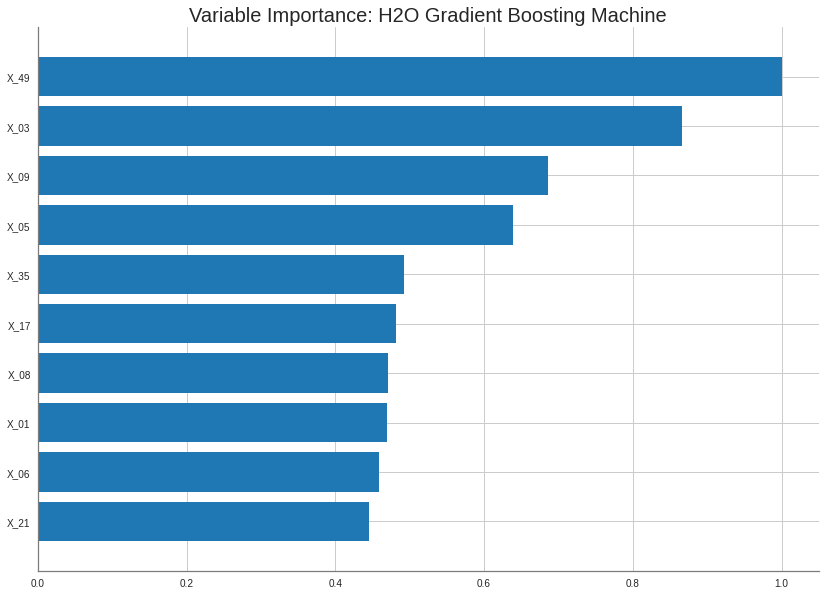

predict
24.1159
24.5839
24.3372
24.616
24.1896
24.2554
24.5797
24.2297
24.4339
24.4748


Y_11
23.045
23.772
23.587
24.858
25.025
24.697
23.275
25.288
23.748
24.513


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_11'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred11 = aml.predict(h2o_test)
pred11

predict
24.2886
24.4904
24.6929
24.85
24.4251
24.8902
24.7951
24.9398
24.8417
24.7701


In [ ]:
# 모델 저장
import pickle

with open('Y_11.pkl', 'wb') as f:
 pickle.dump(pred11, f)

In [ ]:
df = h2o_test.cbind(pred11)
res = df[:, ["predict"]]
res.set_names(['Y_11'])
h2o.export_file(res, path = "pred11.csv", force = True)


##### 12

In [ ]:
# 1시간
train_12 = train12.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_12, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_12.columns)
y = "Y_12"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_6_20220809_102035_model_3,0.620013,0.384416,0.482071,nan,0.384416
GBM_grid_1_AutoML_6_20220809_102035_model_5,0.620132,0.384563,0.482863,nan,0.384563
GBM_grid_1_AutoML_6_20220809_102035_model_15,0.620894,0.385509,0.482883,nan,0.385509
GBM_4_AutoML_6_20220809_102035,0.620977,0.385613,0.483192,nan,0.385613
GBM_1_AutoML_6_20220809_102035,0.621219,0.385914,0.482946,nan,0.385914
GBM_grid_1_AutoML_6_20220809_102035_model_13,0.621397,0.386135,0.482921,nan,0.386135
GBM_grid_1_AutoML_6_20220809_102035_model_7,0.621486,0.386245,0.483477,nan,0.386245
GBM_grid_1_AutoML_6_20220809_102035_model_1,0.62153,0.386299,0.483246,nan,0.386299
GBM_grid_1_AutoML_6_20220809_102035_model_11,0.62213,0.387045,0.484038,nan,0.387045
GBM_grid_1_AutoML_6_20220809_102035_model_22,0.622438,0.387429,0.483799,nan,0.387429


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.38441566211370665
RMSE: 0.6200126306082051
MAE: 0.482071279116585
RMSLE: NaN
Mean Residual Deviance: 0.38441566211370665


[('X_20', 1078.268798828125, 1.0, 0.06713135231148963), ('X_32', 866.6046752929688, 0.8037000386497363, 0.053953470447353276), ('X_49', 831.792236328125, 0.7714145463840987, 0.051786101691518885), ('X_03', 728.1288452148438, 0.6752758180577817, 0.04533217884946631), ('X_07', 641.5178833007812, 0.5949517263209232, 0.039939913947978856), ('X_22', 518.6827392578125, 0.48103287401204864, 0.03229238733871124), ('X_08', 506.42364501953125, 0.46966363634922786, 0.03152915503965536), ('X_21', 484.6026306152344, 0.44942655406695076, 0.030170612339207214), ('X_30', 460.8768310546875, 0.4274229501545197, 0.02869348065283933), ('X_05', 430.4268798828125, 0.3991832837513294, 0.026797713658367823), ('X_09', 375.81939697265625, 0.34853961960236735, 0.023397935998039097), ('X_19', 354.068115234375, 0.3283672082686435, 0.022043734745822597), ('X_36', 327.30908203125, 0.3035505454548748, 0.020377758611276046), ('X_37', 304.92205810546875, 0.2827885388475133, 0.018983977031023787), ('X_40', 304.340881347

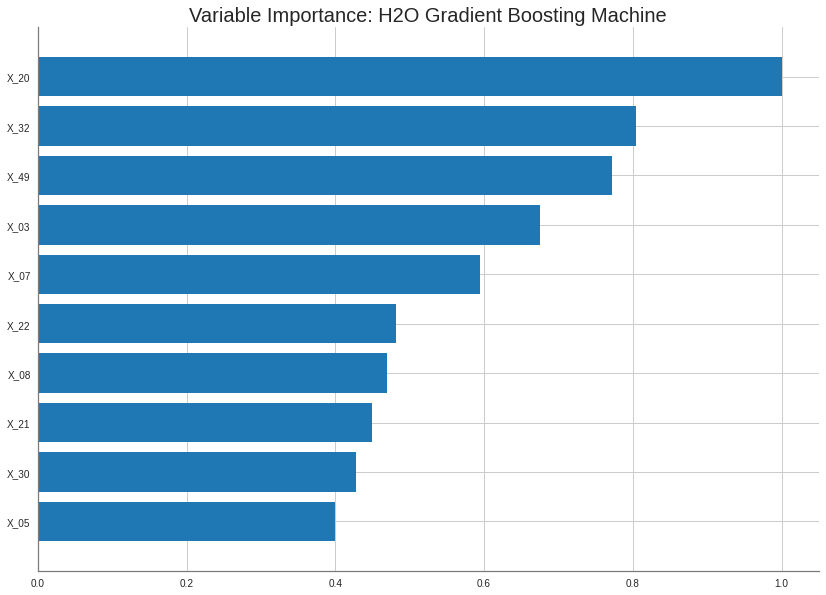

predict
-26.0409
-26.3515
-26.1698
-26.4648
-26.4001
-26.0411
-26.5278
-26.0997
-26.2004
-26.3986


Y_12
-25.274
-26.024
-26.662
-25.361
-26.431
-26.087
-27.661
-25.731
-26.801
-25.769


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_12'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred12 = aml.predict(h2o_test)
pred12

predict
-26.1348
-26.1383
-25.7411
-25.7052
-25.7077
-25.67
-25.7232
-25.546
-25.7017
-25.8074


In [ ]:
# 모델 저장
import pickle

with open('Y_12.pkl', 'wb') as f:
 pickle.dump(pred12, f)

In [ ]:
df = h2o_test.cbind(pred12)
res = df[:, ["predict"]]
res.set_names(['Y_12'])
h2o.export_file(res, path = "pred12.csv", force = True)


##### 13

In [ ]:
# 1시간
train_13 = train13.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_13, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_13.columns)
y = "Y_13"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_2_AutoML_7_20220809_112044,0.623838,0.389174,0.482979,nan,0.389174
GBM_1_AutoML_7_20220809_112044,0.623996,0.389371,0.482881,nan,0.389371
GBM_grid_1_AutoML_7_20220809_112044_model_8,0.625032,0.390665,0.483536,nan,0.390665
GBM_grid_1_AutoML_7_20220809_112044_model_1,0.625111,0.390763,0.483572,nan,0.390763
GBM_5_AutoML_7_20220809_112044,0.625165,0.390831,0.483957,nan,0.390831
GBM_3_AutoML_7_20220809_112044,0.625476,0.391221,0.484176,nan,0.391221
GBM_grid_1_AutoML_7_20220809_112044_model_9,0.625535,0.391294,0.484433,nan,0.391294
GBM_grid_1_AutoML_7_20220809_112044_model_3,0.62565,0.391438,0.484592,nan,0.391438
GBM_4_AutoML_7_20220809_112044,0.625861,0.391702,0.484459,nan,0.391702
GBM_grid_1_AutoML_7_20220809_112044_model_10,0.626076,0.391971,0.484785,nan,0.391971


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.38917394378927445
RMSE: 0.6238380749756097
MAE: 0.482978713902079
RMSLE: NaN
Mean Residual Deviance: 0.38917394378927445


[('X_32', 923.0615234375, 1.0, 0.07091386806086303), ('X_49', 879.7505493164062, 0.9530789952550478, 0.06758651812109635), ('X_03', 706.8123168945312, 0.7657261178673636, 0.054300600893203065), ('X_21', 627.490478515625, 0.6797926926678057, 0.04820672931658358), ('X_20', 618.8366088867188, 0.6704175108308692, 0.04754189890875246), ('X_22', 612.6380615234375, 0.6637023058246008, 0.0470656977469363), ('X_07', 521.5310668945312, 0.5650014150219791, 0.04006643579906954), ('X_08', 448.8870544433594, 0.4863024219357501, 0.03448558578682992), ('X_09', 441.9584045410156, 0.4787962593166634, 0.033953294761216626), ('X_19', 396.3453063964844, 0.42938124527223964, 0.030449084975044668), ('X_30', 279.00909423828125, 0.3022648947593934, 0.021434772866398267), ('X_05', 273.2104187011719, 0.29598289145855705, 0.020989291713164857), ('X_51', 265.98406982421875, 0.2881542162365176, 0.020434130071377805), ('X_56', 252.42578125, 0.2734658252355284, 0.01939251944990729), ('X_54', 240.37481689453125, 0.260

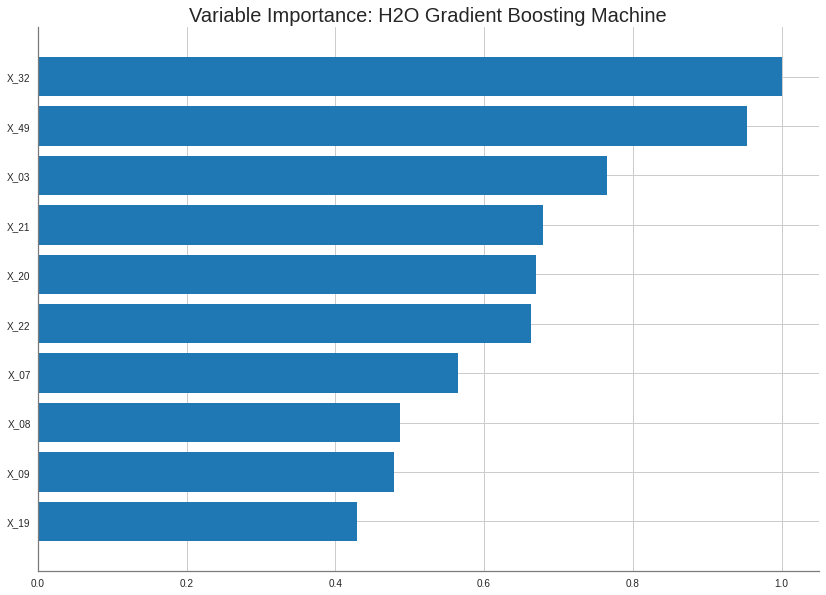

predict
-26.2269
-26.2519
-26.2904
-26.5487
-26.5248
-26.2223
-26.0074
-26.1292
-26.2203
-25.9768


Y_13
-25.887
-25.709
-27.522
-26.041
-26.606
-25.698
-25.641
-25.4
-26.362
-26.657


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_13'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred13 = aml.predict(h2o_test)
pred13

predict
-26.1876
-26.1207
-25.8311
-25.675
-25.7974
-25.7097
-25.6952
-25.4266
-25.6135
-25.8957


In [ ]:
# 모델 저장
import pickle

with open('Y_13.pkl', 'wb') as f:
 pickle.dump(pred13, f)

##### 14

In [ ]:
# 1시간
train_14 = train14.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
train, valid = train_test_split(train_14, test_size=0.333, shuffle=True)
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

x = list(train_14.columns)
y = "Y_14"
x.remove(y)

aml = H2OAutoML(exclude_algos =['XGBoost', 'StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_8_20220809_125304_model_6,0.626419,0.392401,0.487941,nan,0.392401
GBM_3_AutoML_8_20220809_125304,0.626428,0.392412,0.488333,nan,0.392412
GBM_grid_1_AutoML_8_20220809_125304_model_19,0.626554,0.39257,0.488332,nan,0.39257
GBM_1_AutoML_8_20220809_125304,0.626595,0.392622,0.48754,nan,0.392622
GBM_grid_1_AutoML_8_20220809_125304_model_8,0.627008,0.39314,0.488327,nan,0.39314
GBM_grid_1_AutoML_8_20220809_125304_model_9,0.62706,0.393204,0.488677,nan,0.393204
DRF_1_AutoML_8_20220809_125304,0.627442,0.393684,0.489497,nan,0.393684
GBM_5_AutoML_8_20220809_125304,0.627551,0.39382,0.488877,nan,0.39382
GBM_grid_1_AutoML_8_20220809_125304_model_11,0.627872,0.394223,0.489424,nan,0.394223
GBM_2_AutoML_8_20220809_125304,0.627998,0.394381,0.489602,nan,0.394381


In [ ]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set
performance


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.39240112570694685
RMSE: 0.6264192890604079
MAE: 0.4879405154851306
RMSLE: NaN
Mean Residual Deviance: 0.39240112570694685


[('X_20', 1051.7479248046875, 1.0, 0.06539111978515944), ('X_49', 896.4403076171875, 0.8523338021167562, 0.05573506175115718), ('X_07', 792.8643188476562, 0.753853941755952, 0.04929535340587806), ('X_32', 760.3027954101562, 0.7228945049274488, 0.04727088116374433), ('X_03', 627.0309448242188, 0.5961798735573072, 0.038984869525287076), ('X_21', 603.1043701171875, 0.5734305301616693, 0.0374972644862692), ('X_08', 572.779541015625, 0.5445977382099344, 0.03561185593401272), ('X_09', 490.84588623046875, 0.4666953693506172, 0.03051773280038543), ('X_22', 474.9471435546875, 0.4515788739425243, 0.02952924823842302), ('X_30', 403.5520324707031, 0.38369653312664614, 0.025090345958834914), ('X_05', 395.0518798828125, 0.3756146036191844, 0.02456185953831727), ('X_19', 347.131591796875, 0.33005208150169474, 0.021582475196818524), ('X_16', 315.5278015136719, 0.30000325560163693, 0.019617548822984443), ('X_42', 315.4762268066406, 0.29995421846468145, 0.01961434222968787), ('X_45', 314.7597961425781, 

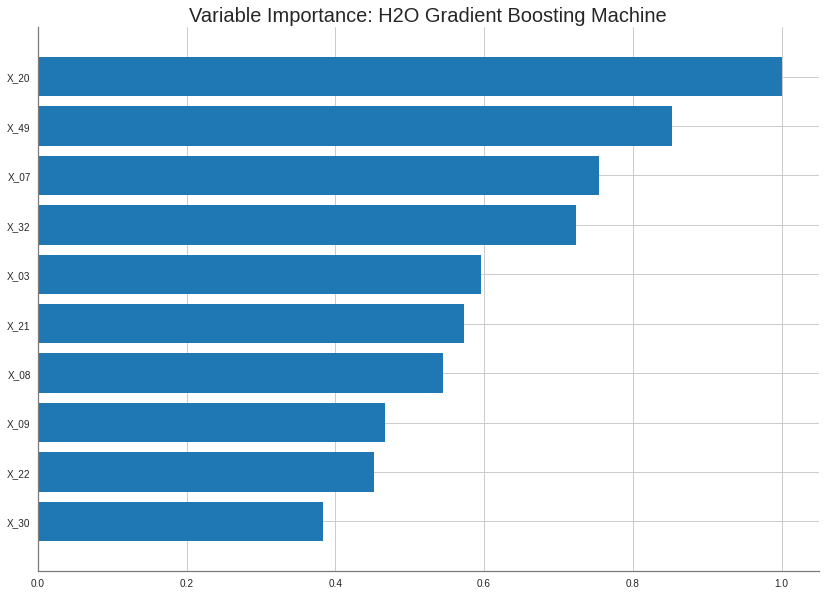

predict
-26.5677
-26.1619
-26.1809
-26.3602
-26.0538
-26.0106
-26.1762
-26.1826
-26.4439
-26.4212


Y_14
-27.939
-26.579
-26.479
-25.526
-26.703
-25.231
-26.064
-26.673
-26.244
-26.265


<Figure size 432x288 with 0 Axes>

In [ ]:
variable_importance = aml.leader.varimp()  # 중요한 입력 변수
print(variable_importance)

## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
get_aml = h2o.automl.get_automl(aml.project_name)
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['Y_14'])

In [ ]:
X_test1 = X_test.drop(columns = ['X_23', 'X_04', 'X_48', 'X_47'], axis=1)
h2o_test = h2o.H2OFrame(X_test1)
pred14 = aml.predict(h2o_test)
pred14

predict
-26.1669
-26.1624
-26.1785
-25.8337
-25.578
-25.5725
-25.6757
-25.2952
-25.6041
-25.8985


In [ ]:
# 모델 저장
import pickle

with open('Y_14.pkl', 'wb') as f:
 pickle.dump(pred14, f)

In [ ]:
df = h2o_test.cbind(pred14)
res = df[:, ["predict"]]
res.set_names(['Y_14'])
h2o.export_file(res, path = "pred14.csv", force = True)


#### pycaret1


In [ ]:
# 모델링
model = setup(train, target = 'Y_01', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = stack_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)

### pycaret

In [ ]:
# pycaret 데이터 제작
for i in range(1, 15):
  globals()['train{0}'.format(i)] = pd.concat([X_train, y_train.iloc[:, i-1:i]],axis=1)

train1.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,Y_01
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,0.0,4.34,0.18,13.34,13.37,13.40,13.52,13.44,3.11,3.17,3.06,3.13,1,2.05,2.07,2.05,2.06,2.06,2.35,1.49,1.69,1.46,1.74,12.99,12.88,12.89,12.99,-16.41,-16.36,-17.03,21.20,20.99,21.28,21.09,0.29,1463,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,2.056
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,0.0,4.38,0.18,13.33,13.33,13.46,13.51,13.42,2.97,3.11,2.91,3.20,1,2.10,2.10,2.10,2.10,2.17,2.28,1.49,1.67,1.45,1.66,12.92,12.87,12.89,12.93,-16.06,-16.11,-16.74,21.16,21.03,21.16,21.13,0.13,1463,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1.446
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,0.0,4.36,0.15,13.36,13.36,13.39,13.51,13.43,3.04,3.04,3.01,3.12,1,2.07,2.06,2.04,2.07,2.10,2.26,1.49,1.69,1.46,1.68,12.97,12.87,12.87,13.00,-16.16,-16.17,-16.76,21.13,21.03,21.17,21.12,0.14,1468,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1.251
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,0.0,4.33,0.21,13.30,13.33,13.39,13.51,13.40,3.05,3.01,3.02,3.08,1,2.06,2.05,2.03,2.06,2.07,2.12,1.47,1.68,1.47,1.68,12.91,12.97,12.99,12.92,-16.05,-16.03,-16.67,21.18,20.98,21.20,21.09,0.22,1469,1,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1.464
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,0.0,4.35,0.16,13.35,13.34,13.41,13.50,13.42,3.04,3.07,3.00,3.12,1,2.09,2.06,2.09,2.12,2.33,2.13,1.49,1.68,1.47,1.82,12.96,12.85,12.91,12.96,-16.25,-16.23,-16.85,21.16,20.96,21.18,21.10,0.22,1469,1,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0.983


#### top5 1~15

In [ ]:
# 모델링 11분
model = setup(train2, target = 'Y_02', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
top5

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2963,0.1426,0.3776,0.0390,0.1871,0.5509,8.647
lightgbm,Light Gradient Boosting Machine,0.2967,0.1427,0.3778,0.0382,0.1871,0.5467,0.487
et,Extra Trees Regressor,0.2968,0.1432,0.3783,0.0353,0.1876,0.5532,12.611
rf,Random Forest Regressor,0.2972,0.1432,0.3783,0.0353,0.1875,0.5476,30.977
lr,Linear Regression,0.2976,0.1438,0.3792,0.0310,0.1879,0.5554,0.293
ridge,Ridge Regression,0.2976,0.1438,0.3792,0.0310,0.1879,0.5554,0.026
br,Bayesian Ridge,0.2977,0.1438,0.3792,0.0307,0.1880,0.5567,0.045
huber,Huber Regressor,0.2972,0.1440,0.3795,0.0296,0.1874,0.5485,0.312
omp,Orthogonal Matching Pursuit,0.2994,0.1450,0.3808,0.0226,0.1888,0.5607,0.026
lar,Least Angle Regression,0.3006,0.1468,0.3831,0.0106,0.1900,0.5570,0.029


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=530, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               ran

In [ ]:
# 모델링 11분
model = setup(train3, target = 'Y_03', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2784,0.1264,0.3555,0.0337,0.1786,0.4038,7.220
lightgbm,Light Gradient Boosting Machine,0.2787,0.1268,0.3560,0.0306,0.1788,0.4019,0.404
et,Extra Trees Regressor,0.2790,0.1268,0.3560,0.0306,0.1790,0.4047,12.176
rf,Random Forest Regressor,0.2795,0.1270,0.3563,0.0291,0.1791,0.4033,30.693
lr,Linear Regression,0.2798,0.1275,0.3571,0.0248,0.1795,0.4071,0.033
ridge,Ridge Regression,0.2798,0.1275,0.3571,0.0248,0.1795,0.4071,0.025
br,Bayesian Ridge,0.2797,0.1276,0.3571,0.0247,0.1796,0.4076,0.057
huber,Huber Regressor,0.2794,0.1278,0.3574,0.0232,0.1791,0.4008,0.411
omp,Orthogonal Matching Pursuit,0.2821,0.1293,0.3596,0.0110,0.1809,0.4120,0.028
lar,Least Angle Regression,0.2822,0.1295,0.3598,0.0096,0.1810,0.4090,0.030


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train4, target = 'Y_04', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.0938,6.9241,2.6274,0.0606,0.1924,0.1735,32.461
et,Extra Trees Regressor,2.0958,6.9282,2.6282,0.0599,0.1925,0.1737,13.315
lightgbm,Light Gradient Boosting Machine,2.0965,6.9423,2.6309,0.0580,0.1929,0.1741,0.418
gbr,Gradient Boosting Regressor,2.1128,7.0342,2.6484,0.0453,0.1940,0.1757,7.408
lr,Linear Regression,2.1256,7.1015,2.6613,0.0360,0.1951,0.1768,0.032
ridge,Ridge Regression,2.1256,7.1014,2.6613,0.0360,0.1951,0.1768,0.025
br,Bayesian Ridge,2.1264,7.1015,2.6613,0.0359,0.1952,0.1768,0.056
huber,Huber Regressor,2.1202,7.1247,2.6658,0.0326,0.1963,0.1781,0.382
omp,Orthogonal Matching Pursuit,2.1471,7.2225,2.6841,0.0192,0.1968,0.1787,0.027
en,Elastic Net,2.1726,7.3652,2.7106,-0.0003,0.1987,0.1809,0.025


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train5, target = 'Y_05', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.0013,6.3115,2.5121,0.0301,0.0811,0.0665,7.457
lightgbm,Light Gradient Boosting Machine,1.9976,6.3125,2.5123,0.0299,0.0811,0.0663,0.407
rf,Random Forest Regressor,2.0080,6.3267,2.5151,0.0277,0.0811,0.0665,35.316
et,Extra Trees Regressor,2.0095,6.3419,2.5182,0.0253,0.0812,0.0666,13.876
lr,Linear Regression,2.0076,6.3475,2.5193,0.0245,0.0813,0.0667,0.033
ridge,Ridge Regression,2.0076,6.3475,2.5193,0.0245,0.0813,0.0667,0.027
br,Bayesian Ridge,2.0080,6.3488,2.5195,0.0243,0.0813,0.0667,0.062
huber,Huber Regressor,1.9859,6.4235,2.5342,0.0129,0.0821,0.0665,0.417
omp,Orthogonal Matching Pursuit,2.0245,6.4494,2.5394,0.0089,0.0820,0.0672,0.028
lar,Least Angle Regression,2.0213,6.4596,2.5415,0.0072,0.0820,0.0671,0.031


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train6, target = 'Y_06', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7593,3.1476,1.7636,0.1572,0.0844,0.0459,0.404
rf,Random Forest Regressor,0.7535,3.5008,1.8559,0.0786,0.0699,0.0454,38.685
et,Extra Trees Regressor,0.7499,3.5250,1.8631,0.0702,0.0552,0.0451,13.719
gbr,Gradient Boosting Regressor,0.7513,3.6239,1.8867,0.0508,0.0591,0.0453,7.392
lr,Linear Regression,0.7368,3.7849,1.9282,0.0091,0.0475,0.0444,0.034
ridge,Ridge Regression,0.7368,3.7849,1.9282,0.0091,0.0475,0.0444,0.027
br,Bayesian Ridge,0.7317,3.7854,1.9282,0.0093,0.0471,0.0441,0.062
omp,Orthogonal Matching Pursuit,0.7317,3.8007,1.9319,0.0056,0.0470,0.0440,0.028
lar,Least Angle Regression,0.7444,3.8020,1.9328,0.0040,0.0481,0.0448,0.032
en,Elastic Net,0.7192,3.8264,1.9381,-0.0004,0.0459,0.0433,0.027


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train7, target = 'Y_07', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3260,0.1685,0.4105,0.0431,0.1005,0.1072,0.393
rf,Random Forest Regressor,0.3260,0.1690,0.4111,0.0402,0.1007,0.1073,33.099
gbr,Gradient Boosting Regressor,0.3267,0.1697,0.4119,0.0363,0.1010,0.1076,7.269
et,Extra Trees Regressor,0.3273,0.1701,0.4124,0.0338,0.1011,0.1078,13.727
lr,Linear Regression,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.032
ridge,Ridge Regression,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.027
br,Bayesian Ridge,0.3279,0.1712,0.4137,0.0279,0.1015,0.1081,0.061
huber,Huber Regressor,0.3273,0.1715,0.4141,0.0260,0.1014,0.1074,0.411
lar,Least Angle Regression,0.3284,0.1717,0.4143,0.0251,0.1016,0.1082,0.031
omp,Orthogonal Matching Pursuit,0.3296,0.1725,0.4153,0.0202,0.1019,0.1086,0.028


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train8, target = 'Y_08', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4891,0.3966,0.6297,0.0864,0.0229,0.0185,32.115
lightgbm,Light Gradient Boosting Machine,0.4897,0.3984,0.6311,0.0822,0.0230,0.0186,0.396
et,Extra Trees Regressor,0.4907,0.3988,0.6315,0.0813,0.0230,0.0186,12.609
gbr,Gradient Boosting Regressor,0.4910,0.4009,0.6332,0.0763,0.0231,0.0186,7.212
br,Bayesian Ridge,0.4968,0.4103,0.6405,0.0546,0.0233,0.0188,0.057
lr,Linear Regression,0.4968,0.4104,0.6406,0.0545,0.0233,0.0188,0.031
ridge,Ridge Regression,0.4968,0.4104,0.6406,0.0545,0.0233,0.0188,0.028
huber,Huber Regressor,0.4948,0.4121,0.6419,0.0505,0.0234,0.0187,0.494
lar,Least Angle Regression,0.4989,0.4138,0.6432,0.0467,0.0234,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4999,0.4155,0.6445,0.0428,0.0235,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train9, target = 'Y_09', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4865,0.3908,0.6251,0.0800,0.0228,0.0184,33.414
lightgbm,Light Gradient Boosting Machine,0.4869,0.3924,0.6264,0.0760,0.0228,0.0184,0.402
et,Extra Trees Regressor,0.4876,0.3927,0.6266,0.0754,0.0228,0.0185,12.661
gbr,Gradient Boosting Regressor,0.4883,0.3952,0.6286,0.0696,0.0229,0.0185,7.231
lr,Linear Regression,0.4938,0.4041,0.6356,0.0486,0.0231,0.0187,0.031
ridge,Ridge Regression,0.4938,0.4041,0.6356,0.0486,0.0231,0.0187,0.025
br,Bayesian Ridge,0.4937,0.4040,0.6356,0.0487,0.0231,0.0187,0.055
lar,Least Angle Regression,0.4948,0.4057,0.6369,0.0447,0.0232,0.0187,0.030
huber,Huber Regressor,0.4918,0.4058,0.6370,0.0446,0.0232,0.0186,0.489
omp,Orthogonal Matching Pursuit,0.4966,0.4087,0.6393,0.0377,0.0233,0.0188,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train10, target = 'Y_10', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6338,0.7457,0.8632,0.1359,0.0358,0.0280,0.407
rf,Random Forest Regressor,0.6386,0.7565,0.8695,0.1233,0.0360,0.0282,32.313
et,Extra Trees Regressor,0.6408,0.7705,0.8775,0.1074,0.0363,0.0283,12.493
gbr,Gradient Boosting Regressor,0.6393,0.7743,0.8796,0.1029,0.0364,0.0282,7.248
lr,Linear Regression,0.6533,0.8081,0.8986,0.0638,0.0372,0.0288,0.022
ridge,Ridge Regression,0.6533,0.8081,0.8986,0.0638,0.0372,0.0288,0.026
br,Bayesian Ridge,0.6531,0.8081,0.8986,0.0637,0.0372,0.0288,0.055
lar,Least Angle Regression,0.6539,0.8091,0.8992,0.0625,0.0372,0.0288,0.030
huber,Huber Regressor,0.6465,0.8171,0.9036,0.0533,0.0373,0.0284,0.419
omp,Orthogonal Matching Pursuit,0.6623,0.8269,0.9090,0.0420,0.0376,0.0292,0.027


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train11, target = 'Y_11', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6378,0.6627,0.8140,0.0369,0.0326,0.0265,0.394
rf,Random Forest Regressor,0.6426,0.6668,0.8166,0.0309,0.0327,0.0267,33.110
gbr,Gradient Boosting Regressor,0.6407,0.6678,0.8172,0.0294,0.0327,0.0266,7.240
et,Extra Trees Regressor,0.6421,0.6679,0.8172,0.0293,0.0327,0.0267,13.123
lr,Linear Regression,0.6457,0.6781,0.8234,0.0146,0.0330,0.0268,0.032
ridge,Ridge Regression,0.6457,0.6781,0.8234,0.0146,0.0330,0.0268,0.017
br,Bayesian Ridge,0.6458,0.6782,0.8235,0.0143,0.0330,0.0268,0.056
omp,Orthogonal Matching Pursuit,0.6477,0.6827,0.8262,0.0078,0.0331,0.0269,0.027
huber,Huber Regressor,0.6412,0.6836,0.8268,0.0065,0.0331,0.0267,0.423
lar,Least Angle Regression,0.6492,0.6856,0.8280,0.0036,0.0331,0.0270,0.030


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=530, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 모델링 11분
model = setup(train12, target = 'Y_12', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4882,0.3934,0.6271,0.0821,0.0229,0.0186,32.361
et,Extra Trees Regressor,0.4890,0.3943,0.6279,0.0799,0.0229,0.0186,12.615
lightgbm,Light Gradient Boosting Machine,0.4882,0.3945,0.6280,0.0795,0.0229,0.0185,0.407
gbr,Gradient Boosting Regressor,0.4899,0.3977,0.6306,0.0719,0.0230,0.0186,7.219
lr,Linear Regression,0.4953,0.4069,0.6379,0.0503,0.0233,0.0188,0.021
ridge,Ridge Regression,0.4953,0.4069,0.6379,0.0503,0.0233,0.0188,0.025
br,Bayesian Ridge,0.4953,0.4069,0.6379,0.0504,0.0233,0.0188,0.048
huber,Huber Regressor,0.4934,0.4087,0.6393,0.0461,0.0233,0.0187,0.491
lar,Least Angle Regression,0.4968,0.4093,0.6397,0.0449,0.0234,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4985,0.4120,0.6419,0.0385,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train13, target = 'Y_13', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4864,0.3909,0.6252,0.0833,0.0228,0.0185,32.161
et,Extra Trees Regressor,0.4870,0.3915,0.6257,0.0818,0.0228,0.0185,12.517
lightgbm,Light Gradient Boosting Machine,0.4870,0.3925,0.6265,0.0794,0.0229,0.0185,0.402
gbr,Gradient Boosting Regressor,0.4883,0.3952,0.6286,0.0732,0.0230,0.0186,7.206
br,Bayesian Ridge,0.4939,0.4045,0.6359,0.0514,0.0232,0.0188,0.056
lr,Linear Regression,0.4939,0.4045,0.6360,0.0513,0.0232,0.0188,0.032
ridge,Ridge Regression,0.4939,0.4045,0.6360,0.0513,0.0232,0.0188,0.015
lar,Least Angle Regression,0.4943,0.4049,0.6363,0.0503,0.0232,0.0188,0.031
huber,Huber Regressor,0.4921,0.4062,0.6373,0.0473,0.0233,0.0187,0.488
omp,Orthogonal Matching Pursuit,0.4972,0.4096,0.6400,0.0393,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train14, target = 'Y_14', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4878,0.3930,0.6268,0.0809,0.0229,0.0185,32.223
et,Extra Trees Regressor,0.4887,0.3937,0.6274,0.0793,0.0229,0.0186,12.532
lightgbm,Light Gradient Boosting Machine,0.4877,0.3937,0.6275,0.0791,0.0229,0.0185,0.407
gbr,Gradient Boosting Regressor,0.4896,0.3967,0.6298,0.0721,0.0230,0.0186,7.219
lr,Linear Regression,0.4952,0.4061,0.6372,0.0502,0.0233,0.0188,0.033
ridge,Ridge Regression,0.4952,0.4061,0.6372,0.0502,0.0233,0.0188,0.027
br,Bayesian Ridge,0.4952,0.4060,0.6372,0.0503,0.0233,0.0188,0.056
huber,Huber Regressor,0.4934,0.4077,0.6385,0.0463,0.0233,0.0187,0.488
lar,Least Angle Regression,0.4967,0.4081,0.6388,0.0453,0.0233,0.0189,0.030
omp,Orthogonal Matching Pursuit,0.4984,0.4111,0.6411,0.0386,0.0234,0.0189,0.026


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=530, verbose=0, warm_start=False)

In [ ]:
# 모델링 11분
model = setup(train15, target = 'Y_15', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
compare_models(exclude = ['svm'],sort='RMSE')


NameError: ignored

#### tune

In [ ]:
# 모델링 11분
model = setup(train1, target = 'Y_01', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm', 'rf'],round=2,n_select=4,sort='RMSE')
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2725,0.1253,0.3540,0.0060,0.1550,0.2740
1,0.2750,0.1289,0.3590,0.0212,0.1567,0.2851
2,0.2684,0.1198,0.3461,0.0060,0.1516,0.2594
3,0.2696,0.1214,0.3485,0.0147,0.1566,0.3437
4,0.2744,0.1252,0.3538,0.0131,0.1564,0.3008
5,0.2804,0.1345,0.3667,-0.0335,0.1619,0.2976
6,0.2797,0.1307,0.3616,-0.0110,0.1578,0.2713
7,0.2720,0.1245,0.3528,0.0345,0.1538,0.2721
8,0.2775,0.1237,0.3517,-0.0005,0.1527,0.2595


In [ ]:
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 0:1])

### create_model

In [ ]:
# 랜덤포레스트 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 0:1].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

[I 2022-08-07 11:41:29,839] A new study created in memory with name: no-name-71a3495d-4121-4616-88eb-ba670016e162
[I 2022-08-07 11:51:23,351] Trial 0 finished with value: 0.36674092340537595 and parameters: {'n_estimators': 780, 'max_features': 43}. Best is trial 0 with value: 0.36674092340537595.
[I 2022-08-07 11:54:57,736] Trial 1 finished with value: 0.36531153459409443 and parameters: {'n_estimators': 340, 'max_features': 35}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:04:09,492] Trial 2 finished with value: 0.36759636915345245 and parameters: {'n_estimators': 930, 'max_features': 33}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:12:12,539] Trial 3 finished with value: 0.36745905034311943 and parameters: {'n_estimators': 560, 'max_features': 50}. Best is trial 1 with value: 0.36531153459409443.
[I 2022-08-07 12:13:56,513] Trial 4 finished with value: 0.36706668993084374 and parameters: {'n_estimators': 140, 'max_features': 40}. Best is tr

Best trial: score 0.36531153459409443,
params {'n_estimators': 340, 'max_features': 35}


In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 0:1])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1



In [ ]:
y1 = final_model1.predict(X_test)
# 모델 저장
import pickle
with open('y1.pkl', 'wb') as f:
 pickle.dump(y1, f)

# 리스트 불러오기
import pickle

with open("y1.pkl","rb") as f:
   y1 = pickle.load(f)

In [ ]:
len(y1)

39608

#### 2번

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 1:2].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

[I 2022-08-07 15:41:33,813] A new study created in memory with name: no-name-cd803a8f-4418-44fc-8e21-e2cc34b29e89
[I 2022-08-07 15:42:48,611] Trial 0 finished with value: 0.39543248419295607 and parameters: {'n_estimators': 270, 'max_features': 41}. Best is trial 0 with value: 0.39543248419295607.
[I 2022-08-07 15:47:18,063] Trial 1 finished with value: 0.3926339804710848 and parameters: {'n_estimators': 890, 'max_features': 46}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:48:16,219] Trial 2 finished with value: 0.3955521492923376 and parameters: {'n_estimators': 210, 'max_features': 37}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:49:53,392] Trial 3 finished with value: 0.39585154341504 and parameters: {'n_estimators': 410, 'max_features': 33}. Best is trial 1 with value: 0.3926339804710848.
[I 2022-08-07 15:53:39,332] Trial 4 finished with value: 0.396036266794719 and parameters: {'n_estimators': 930, 'max_features': 35}. Best is trial 1 with

Best trial: score 0.3926339804710848,
params {'n_estimators': 890, 'max_features': 46}


In [ ]:
# 최적의 하이퍼파라미터 직접 대입 45분
et2 = create_model('et', n_estimators=890, max_features=46)

# 나머지 모델(22분)
lgbm2 = create_model('lightgbm')
gbr2 = create_model('gbr')
tune_lgbm2 = tune_model(lgbm2) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr2 = tune_model(gbr2) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2664,0.1203,0.3469,0.0456,0.1518,0.2667
1,0.2705,0.1259,0.3549,0.0436,0.1546,0.2790
2,0.2590,0.1126,0.3355,0.0659,0.1469,0.2502
3,0.2622,0.1151,0.3392,0.0665,0.1524,0.3297
4,0.2665,0.1193,0.3454,0.0594,0.1527,0.2871
5,0.2675,0.1232,0.3510,0.0531,0.1552,0.2847
6,0.2714,0.1243,0.3525,0.0389,0.1537,0.2634
7,0.2693,0.1227,0.3503,0.0484,0.1528,0.2703
8,0.2671,0.1172,0.3423,0.0518,0.1483,0.2472


INFO:logs:create_model_container: 35
INFO:logs:master_model_container: 35
INFO:logs:display_container: 19
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0005, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=530, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, et], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model2 = finalize_model(blender_top5)
final_model2.fit(X_train, y_train.iloc[:, 1:2])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model2.model', 'wb'))
# 모델 불러오기
final_model2 = joblib.load(open('final_model2.model', 'rb'))
final_model2

INFO:logs:Initializing blend_models()
INFO:logs:blend_models(estimator_list=[LGBMRegressor(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=71, min_child_weight=0.001, min_split_gain=0.4,
              n_estimators=300, n_jobs=-1, num_leaves=80, objective=None,
              random_state=530, reg_alpha=0.2, reg_lambda=1e-06, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0005, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=9,
                  

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:54:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Getting model names
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(bagging_fraction=0.9, bagging_freq=2,
                                           boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           feature_fraction=1.0,
                                           importance_type='split',
                                           learning_rate=0.05, max_depth=-1,
                                           min_child_samples=71,
                                           min_child_weight=0.001,
                                           min_split_gain=0.4, n_estimators=300,
                   

In [ ]:
y2 = final_model2.predict(X_test)
# 모델 저장
import pickle
with open('y2.pkl', 'wb') as f:
 pickle.dump(y2, f)

# 리스트 불러오기
import pickle

with open("y2.pkl","rb") as f:
   y2 = pickle.load(f)

#### 3번

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 2:3].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 2:3])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 4번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 3:4].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 3:4].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 3:4])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 5번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 5:6].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 5:6])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 6번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 6:7].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 6:7].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 6:7])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 7번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 7:8].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 7:8])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 8번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 8:9].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 8:9].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 8:9])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 9번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 9:10].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 9:10].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 9:10])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 10번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 10:11].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 10:11].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 10:11])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 11번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 11:12].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf2 = create_model('rf', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
gbr = create_model('gbr')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 
tune_gbr = tune_model(gbr) 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 11:12])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 12번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 12:13].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 12:13].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 12:13])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 13번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 13:14].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 13:14].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 13:14])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

#### 14번

In [ ]:
# rf 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 14:15].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# et 최적 하이퍼파라미터 구하기
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 30, X.shape[1], step=1), # 변수의 개수
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    et = ExtraTreesRegressor(**param)
    et = et.fit(X_train1, y_train1)
    
    score = RMSE(y_val, et.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, X_train.values, y_train.iloc[:, 14:15].values), n_trials=5)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) 

In [ ]:
# 최적의 하이퍼파라미터 직접 대입
rf = create_model('rf', n_estimators=340, max_features=35)
et = create_model('et', n_estimators=340, max_features=35)

# 나머지 모델(22분)
lgbm = create_model('lightgbm')
tune_lgbm = tune_model(lgbm) # tune_model(lgbm, optimize = 'RMSE') 

In [ ]:
# 최종 모델 (56분) 
blender_top5 = blend_models(estimator_list=[tune_lgbm, tune_gbr, rf2], optimize = 'RMSE') # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model.fit(X_train, y_train.iloc[:, 14:15])

# 모델 저장
import joblib
joblib.dump(final_model, open('final_model1.model', 'wb'))
# 모델 불러오기
final_model1 = joblib.load(open('final_model1.model', 'rb'))
final_model1

### Y_01

In [ ]:
model = setup(train_01, target = 'Y_01', session_id=SEED )

,Description,Value
0,session_id,42
1,Target,Y_01
2,Original Data,"(39607, 57)"
3,Missing Values,False
4,Numeric Features,50
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27724, 68)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2685,0.1203,0.3469,4.690000e-02,0.1525,0.2789,0.385
gbr,Gradient Boosting Regressor,0.2681,0.1204,0.3469,4.660000e-02,0.1526,0.2819,6.959
rf,Random Forest Regressor,0.2684,0.1204,0.3470,4.600000e-02,0.1526,0.2779,29.465
et,Extra Trees Regressor,0.2692,0.1215,0.3485,3.770000e-02,0.1534,0.2834,12.186
ridge,Ridge Regression,0.2707,0.1225,0.3499,2.980000e-02,0.1541,0.2863,0.031
br,Bayesian Ridge,0.2710,0.1228,0.3504,2.740000e-02,0.1543,0.2867,0.104
omp,Orthogonal Matching Pursuit,0.2721,0.1236,0.3516,2.060000e-02,0.1548,0.2874,0.030
ada,AdaBoost Regressor,0.2736,0.1244,0.3527,1.440000e-02,0.1557,0.2889,2.713
lr,Linear Regression,0.2744,0.1254,0.3541,6.700000e-03,0.1558,0.2887,0.340
lasso,Lasso Regression,0.2747,0.1260,0.3550,1.600000e-03,0.1562,0.2900,0.035


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_01 = create_model('lightgbm', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2670,0.1189,0.3447,0.0497,0.1534,0.3292
1,0.2699,0.1221,0.3494,0.0432,0.1517,0.2488
2,0.2657,0.1151,0.3393,0.0504,0.1486,0.2430
3,0.2612,0.1159,0.3404,0.0681,0.1496,0.3040
4,0.2701,0.1192,0.3453,0.0438,0.1523,0.2509
5,0.2748,0.1268,0.3561,0.0376,0.1564,0.2955
6,0.2672,0.1182,0.3438,0.0394,0.1516,0.2825
7,0.2719,0.1244,0.3527,0.0476,0.1550,0.2902
8,0.2663,0.1201,0.3465,0.0489,0.1545,0.2969


###Y_02

In [ ]:
model = setup(train_02, target = 'Y_02', session_id=SEED )

,Description,Value
0,session_id,42
1,Target,Y_02
2,Original Data,"(39607, 57)"
3,Missing Values,False
4,Numeric Features,50
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27724, 68)"


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2975,0.1427,0.3778,0.0381,0.1875,0.5409,6.985
rf,Random Forest Regressor,0.2982,0.1428,0.3779,0.0377,0.1876,0.5382,29.518
lightgbm,Light Gradient Boosting Machine,0.2977,0.1429,0.3779,0.0373,0.1875,0.5359,0.366
et,Extra Trees Regressor,0.2987,0.1436,0.3789,0.0326,0.1881,0.5443,12.286
ridge,Ridge Regression,0.2991,0.1440,0.3795,0.0295,0.1884,0.5475,0.023
br,Bayesian Ridge,0.2995,0.1443,0.3799,0.0272,0.1886,0.5491,0.088
omp,Orthogonal Matching Pursuit,0.3003,0.1448,0.3805,0.0242,0.1889,0.5480,0.025
lr,Linear Regression,0.3021,0.1466,0.3829,0.0118,0.1900,0.5493,0.039
en,Elastic Net,0.3041,0.1483,0.3851,0.0005,0.1913,0.5504,0.024
lasso,Lasso Regression,0.3041,0.1483,0.3851,0.0005,0.1913,0.5504,0.025


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sample_submission

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0
